**Importing the necessary Python Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import Huber


**Downloading the needed data as a Dataframe from yfinance**

In [ ]:
ticker = ["RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "TCS.NS", "KOTAKBANK.NS","TATASTEEL.NS"]
company_data = yf.download(ticker, start="2012-01-01", end="2024-09-26")
end = datetime.now()
start = datetime(2012, 1, 1)

company_data.to_csv("data.csv")

company_data = {}
for stock in ticker:
    company_data[stock] = yf.download(stock, start=start, end=end)
    company_data[stock]['Company'] = stock

df = pd.concat(company_data.values(), axis=0)
print(df.tail())

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-26  162.000000  165.899994  160.479996  165.610001  165.610001   
2024-09-27  167.000000  169.009995  165.889999  166.550003  166.550003   
2024-09-30  167.500000  170.179993  167.259995  168.550003  168.550003   
2024-10-01  169.490005  169.490005  165.100006  167.029999  167.029999   
2024-10-03  165.500000  169.990005  164.520004  166.979996  166.979996   

              Volume       Company  
Date                                
2024-09-26  88661662  TATASTEEL.NS  
2024-09-27  72795668  TATASTEEL.NS  
2024-09-30  92381529  TATASTEEL.NS  
2024-10-01  50761579  TATASTEEL.NS  
2024-10-03  75959797  TATASTEEL.NS  


**Value Visualisation**

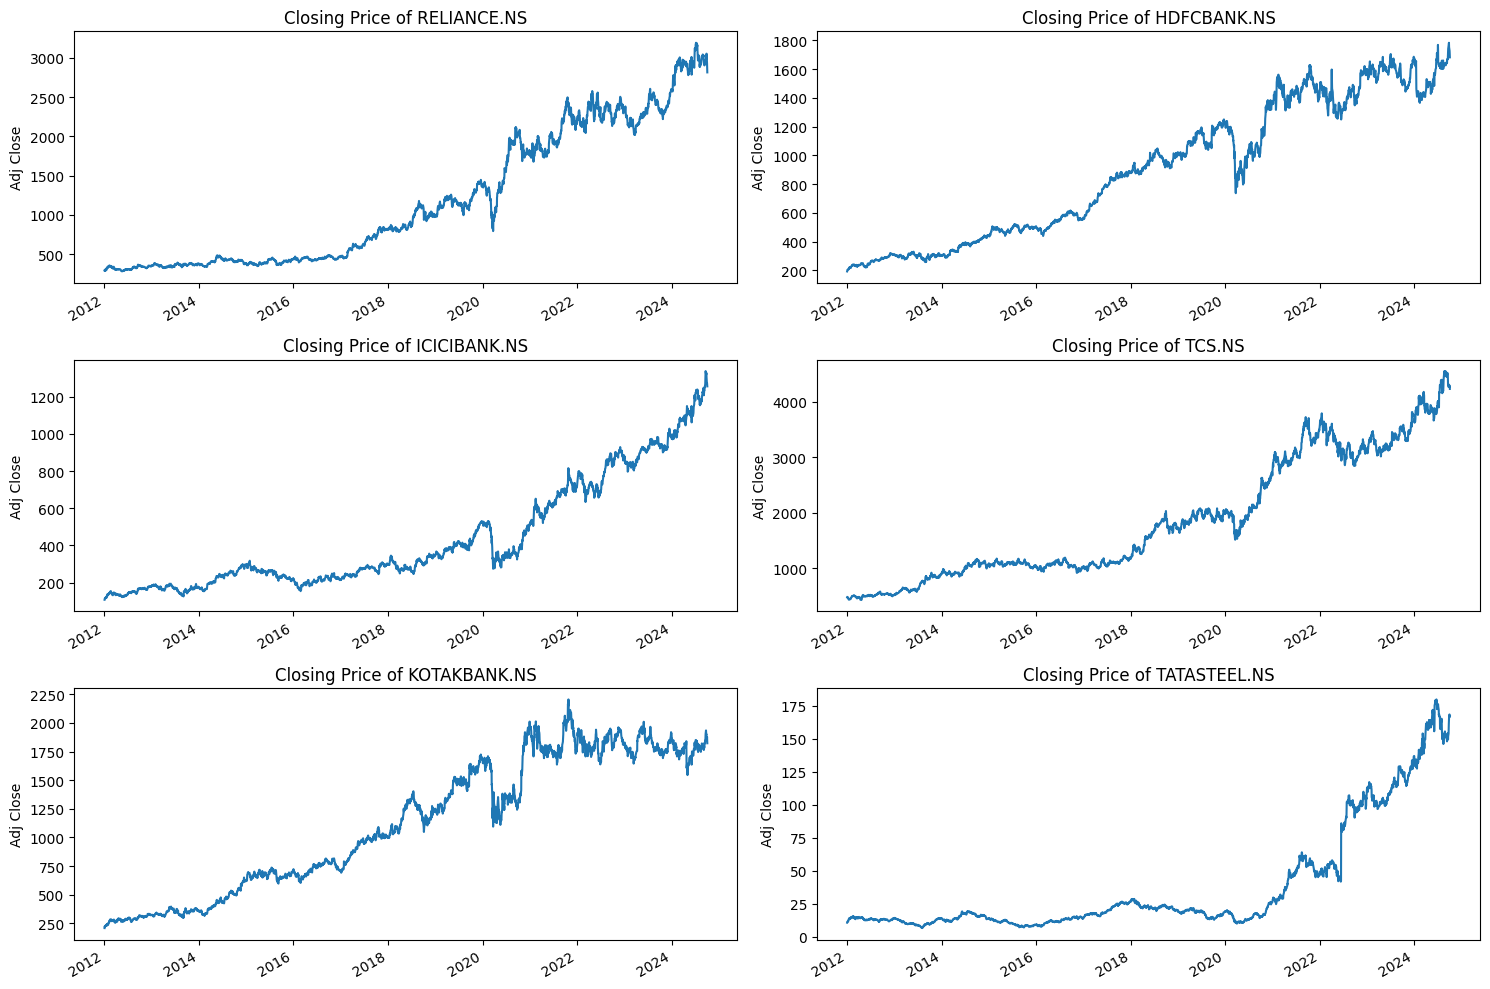

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, (company, data) in enumerate(company_data.items(), 1):
    plt.subplot(3, 2, i)
    data['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company}")

plt.tight_layout()

**Moving Average calculation of the stocks**

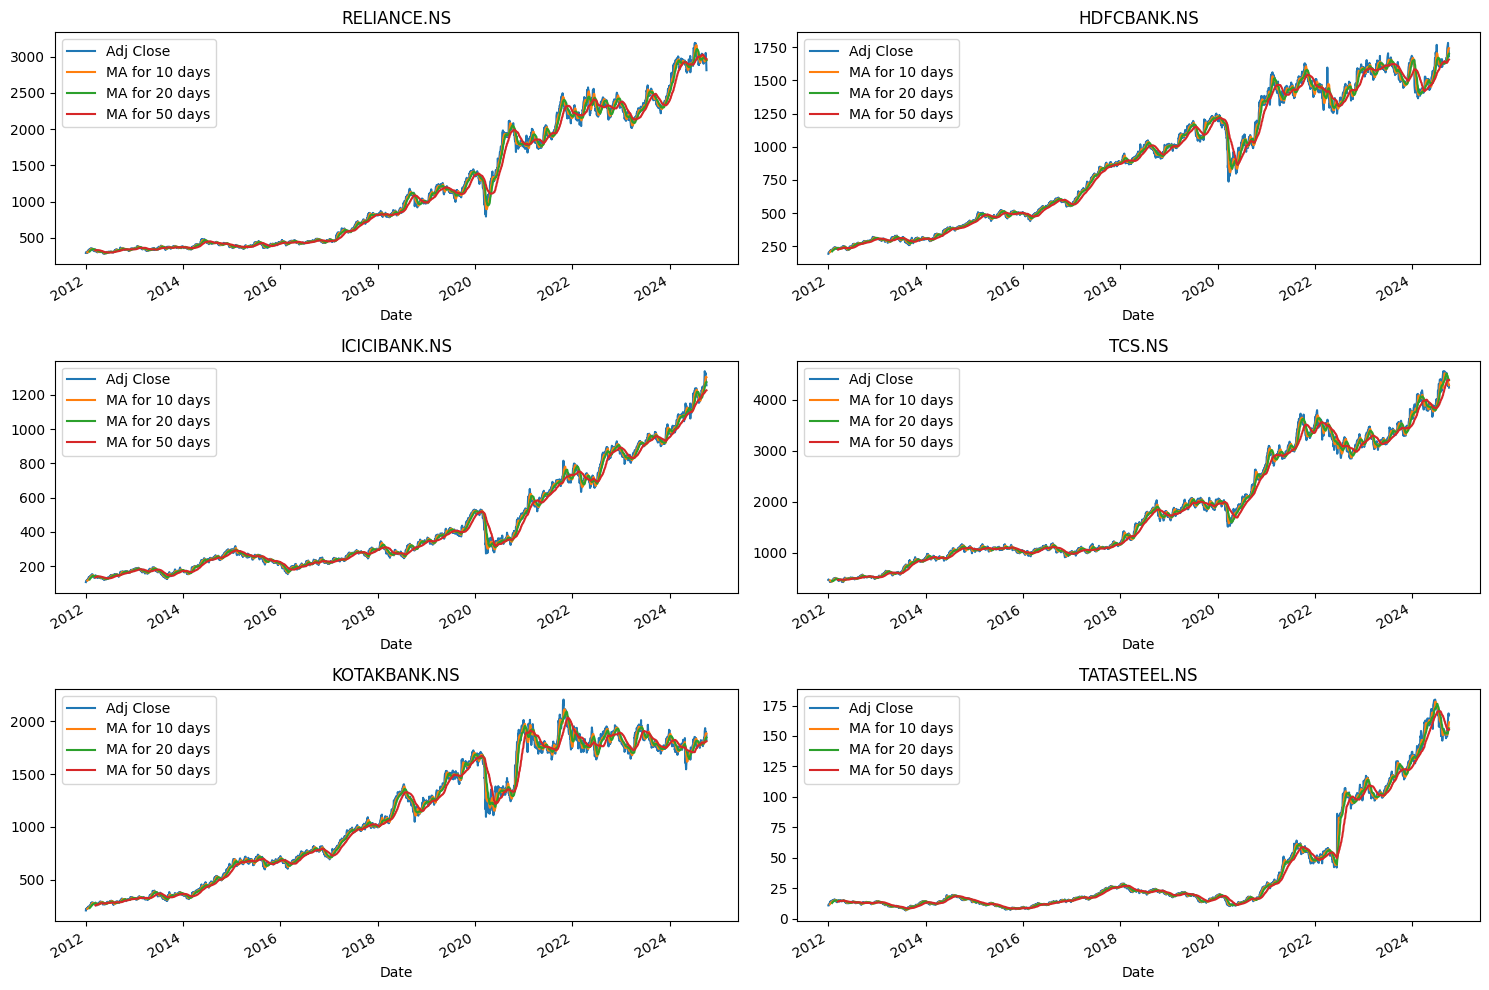

In [ ]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for stock, data in company_data.items():
        data[f"MA for {ma} days"] = data['Adj Close'].rolling(ma).mean()

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

for i, (company, data) in enumerate(company_data.items()):
    row, col = divmod(i, 2)
    data[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[row, col])
    axes[row, col].set_title(company)

fig.tight_layout()

**Daily returns of each Stocks in Histogram**

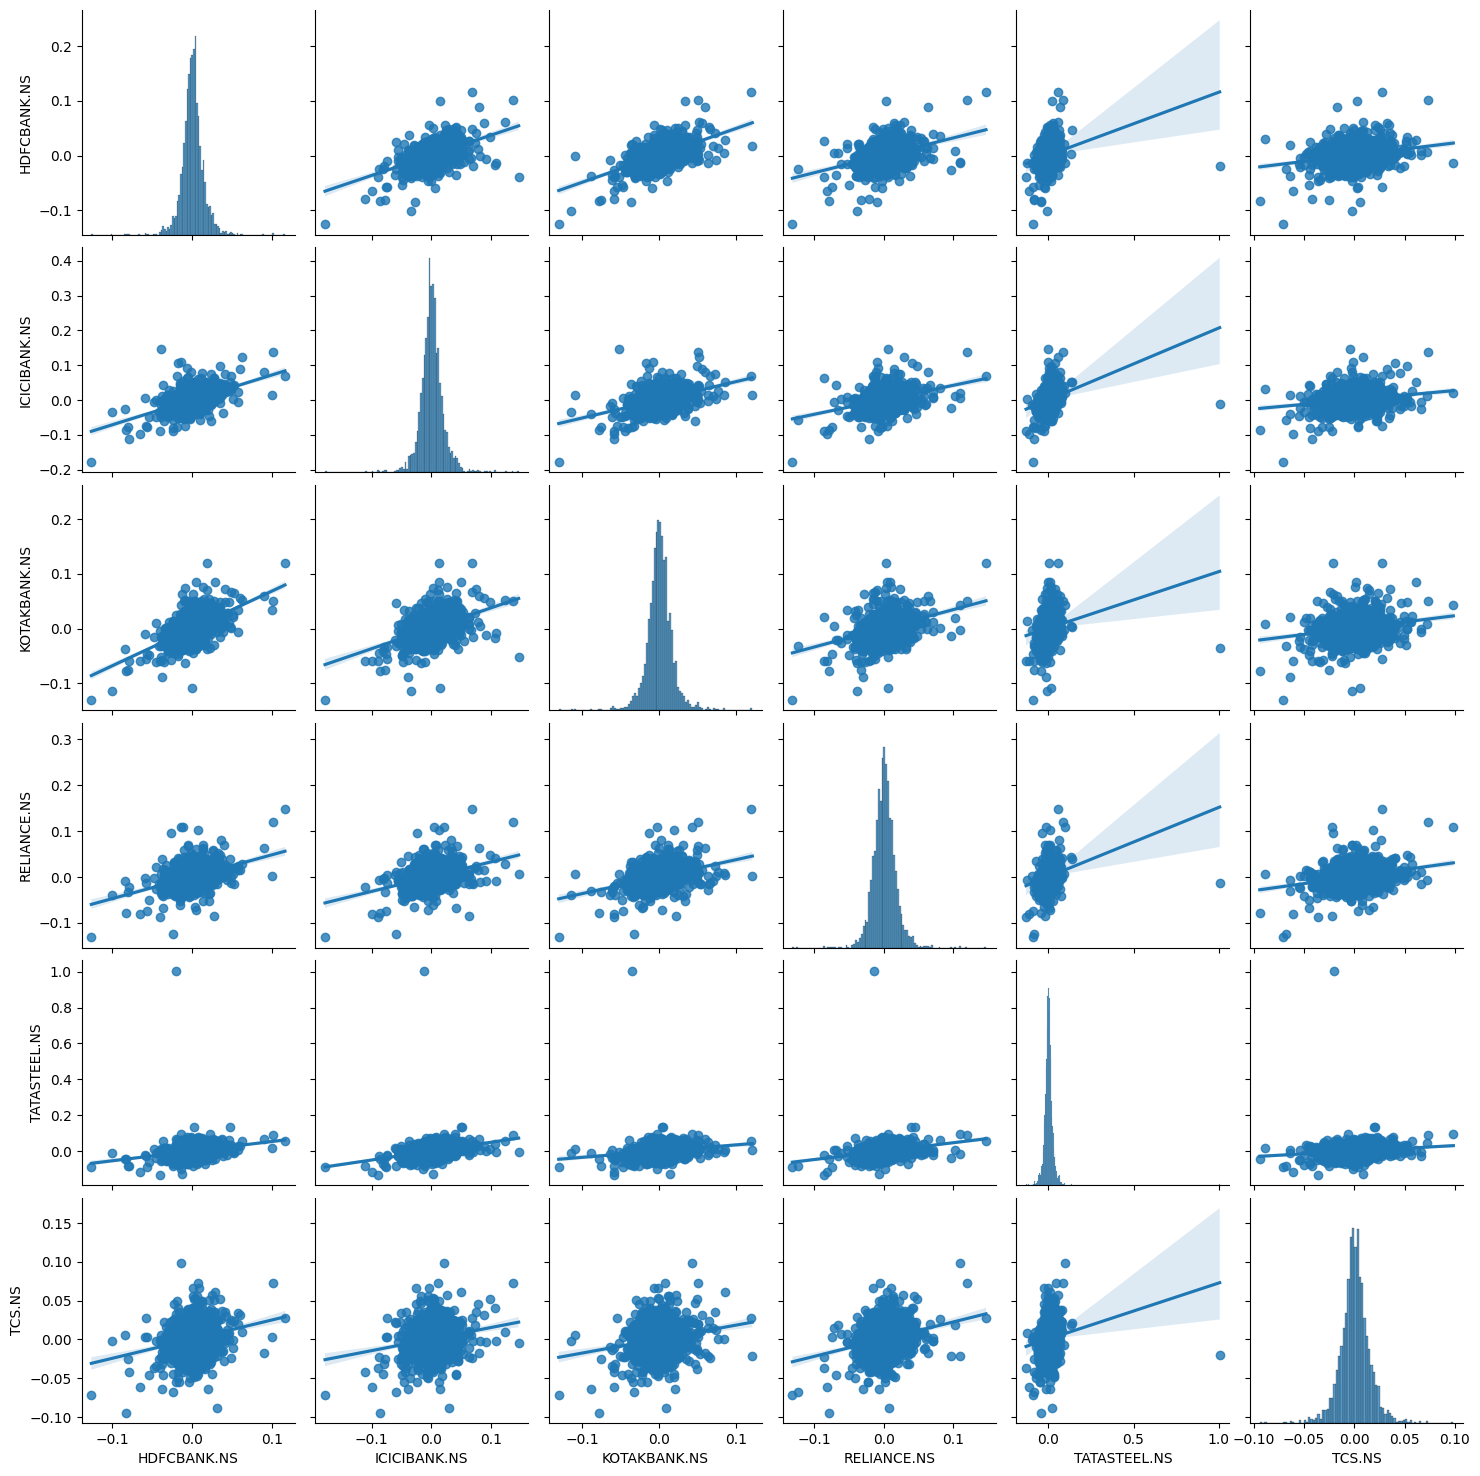

In [ ]:
sns.pairplot(tech_rets, kind='reg')

**Heat Map and KDE Plot**

Text(0.5, 1.0, 'Correlation of stock closing price')

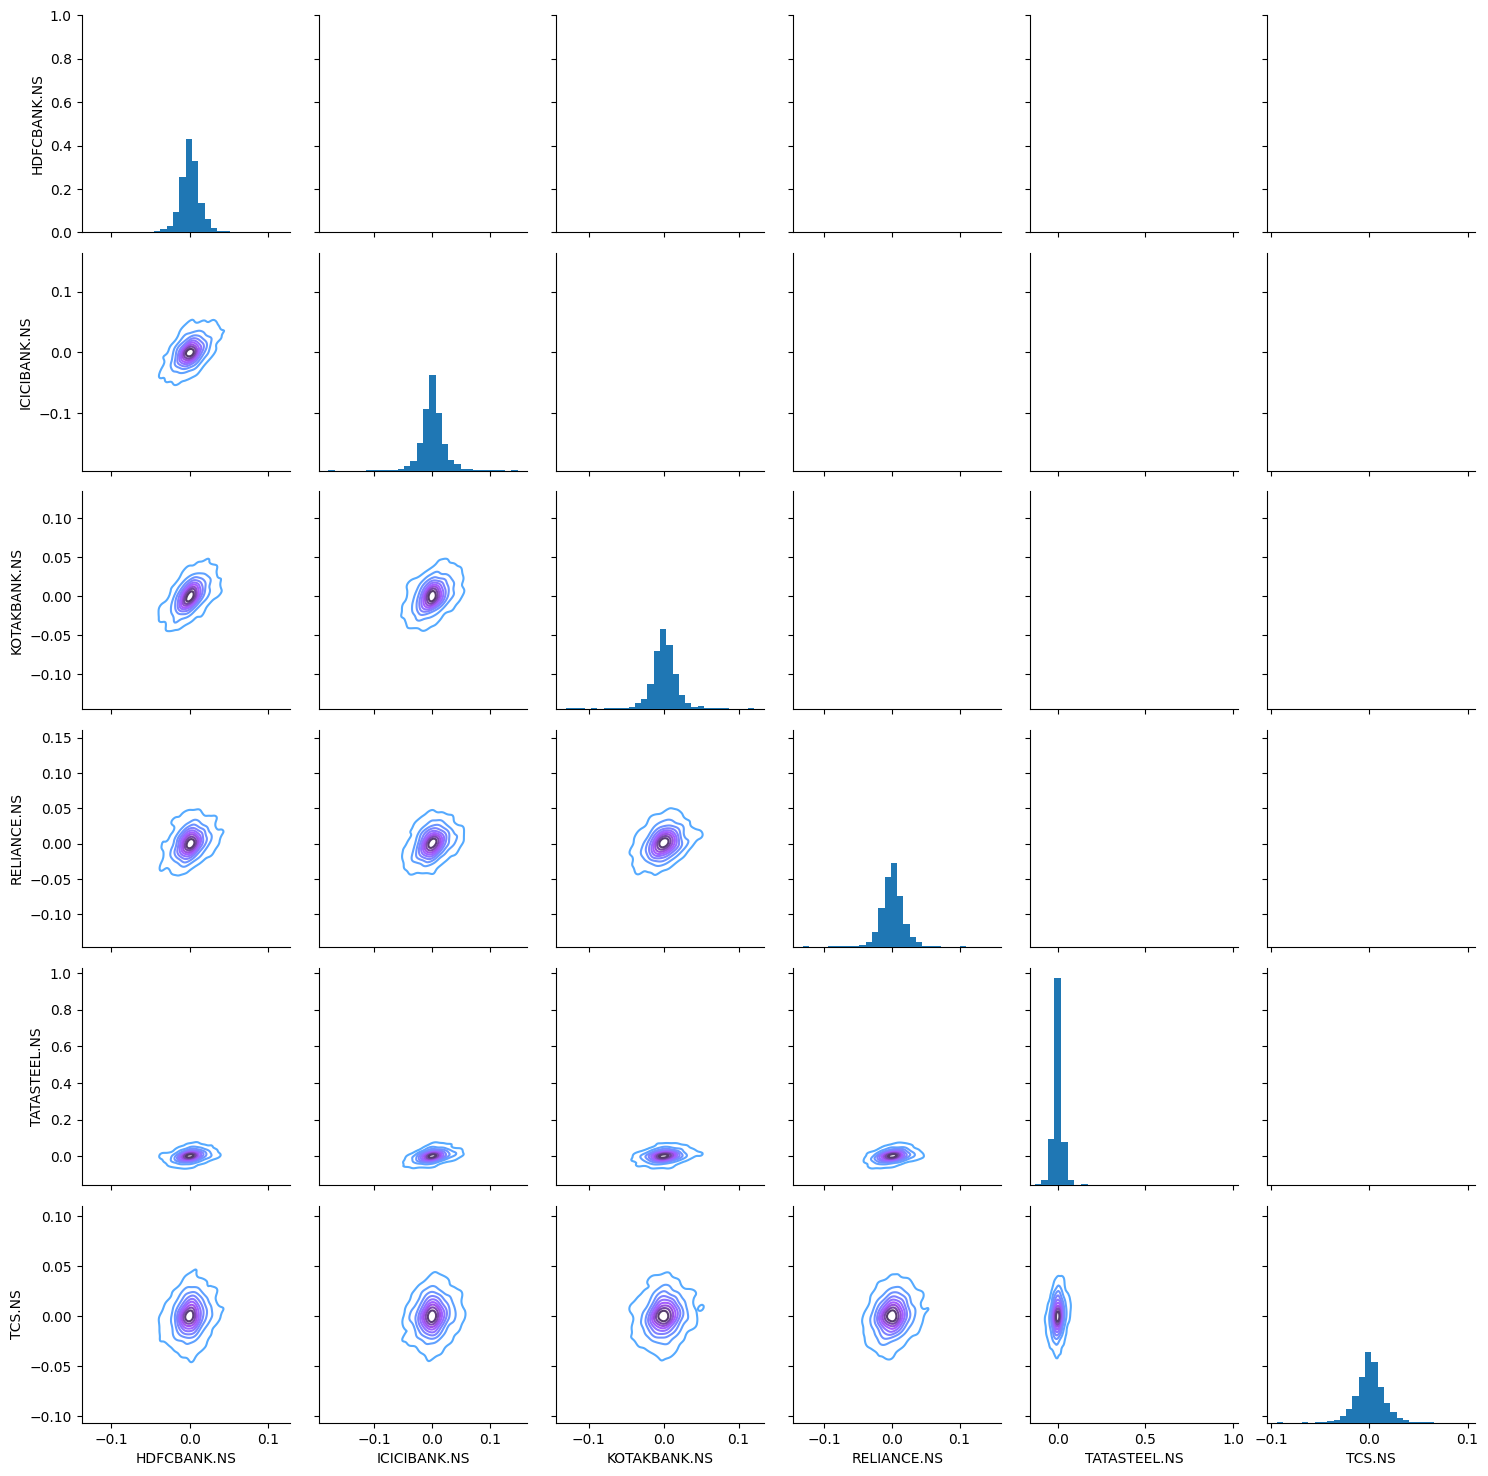

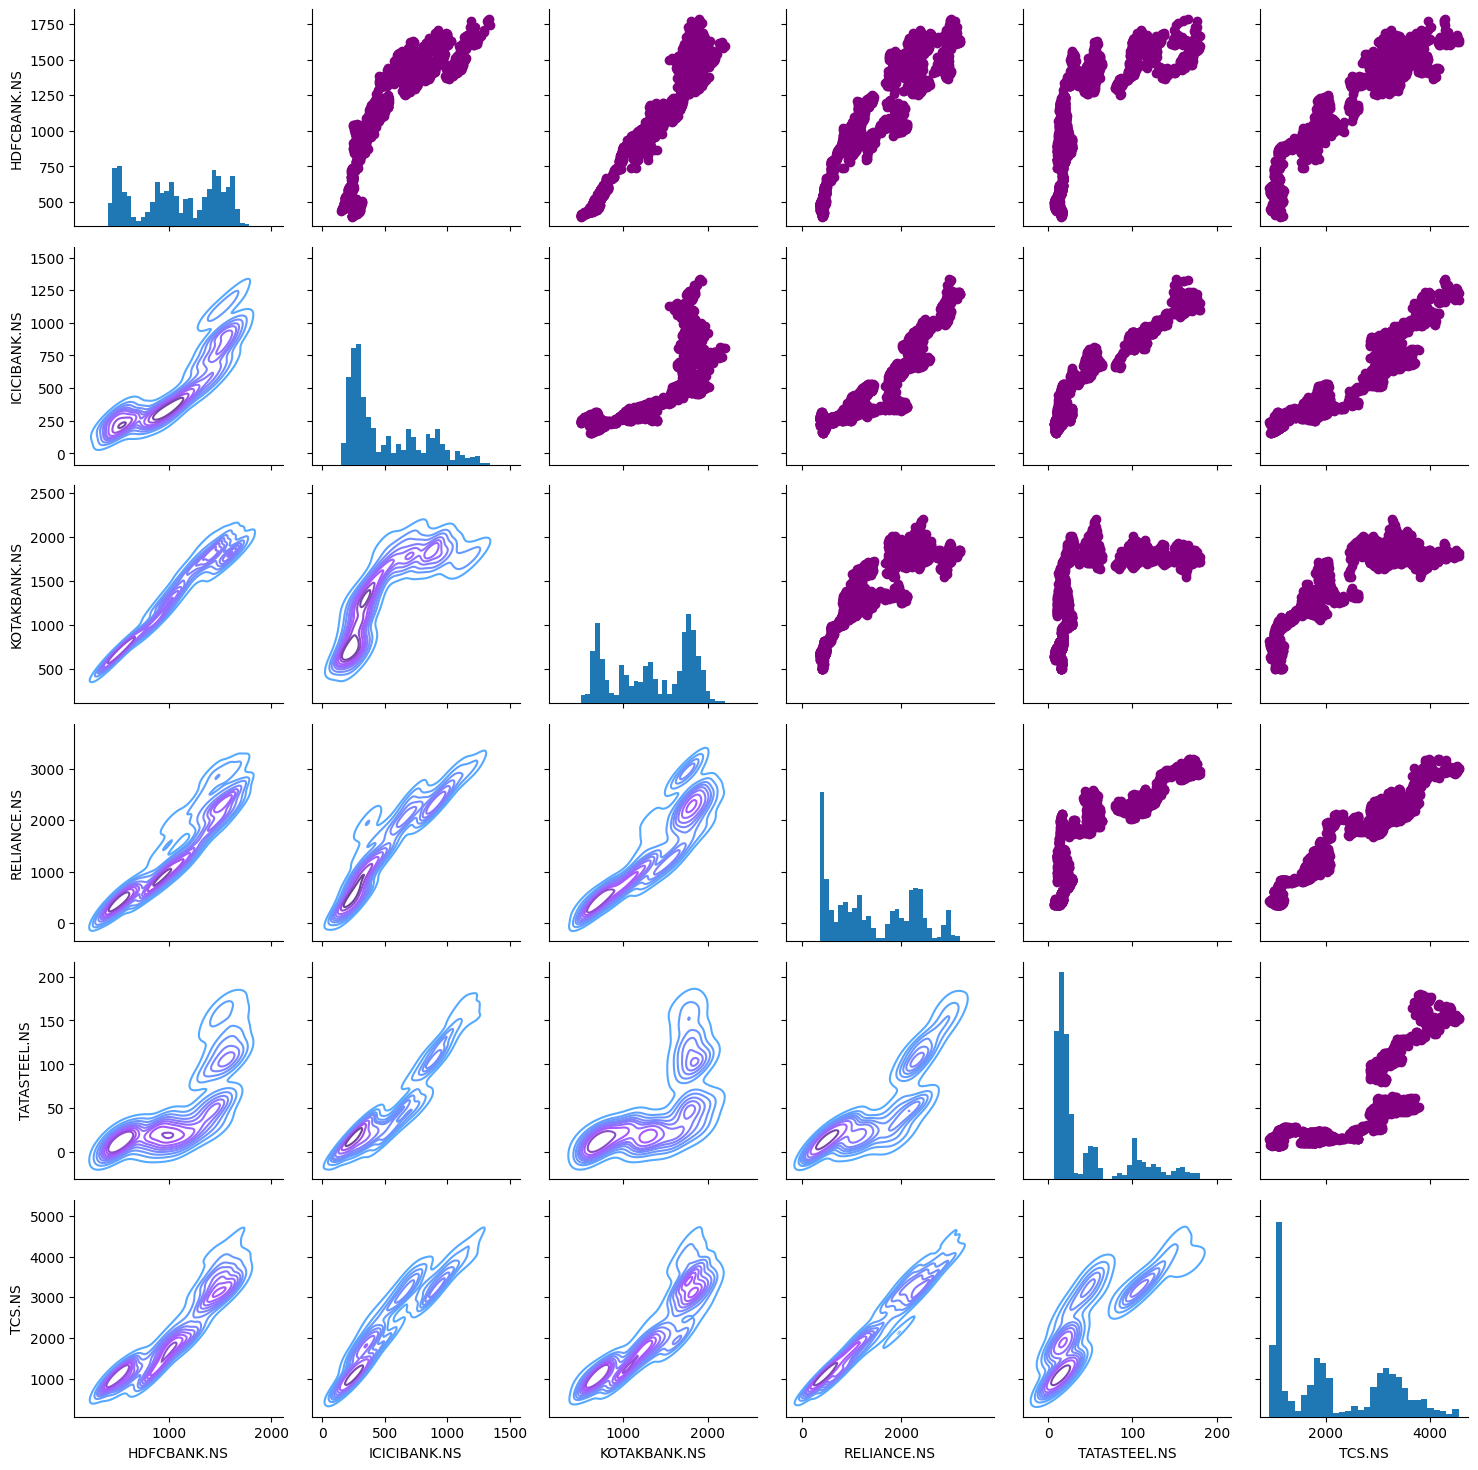

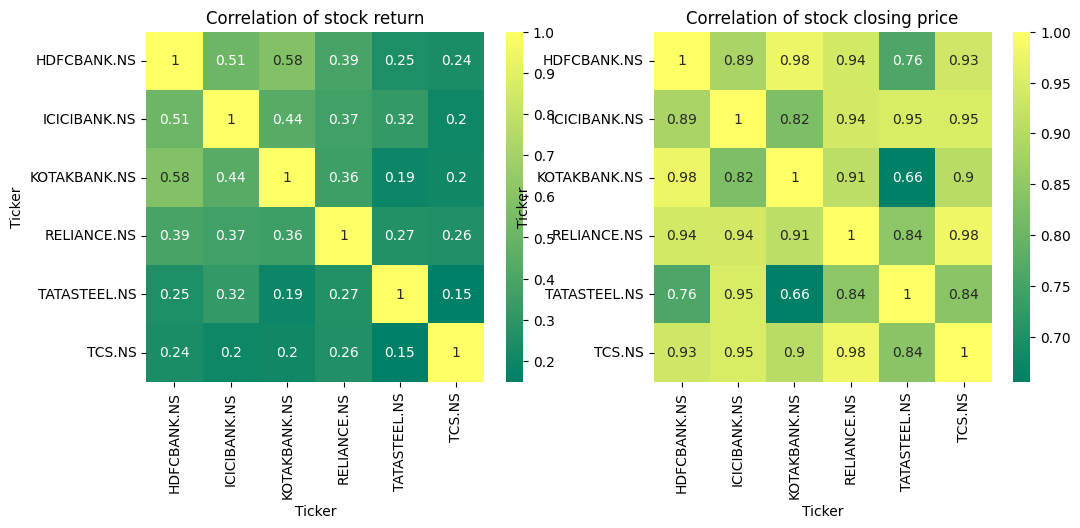

In [ ]:
return_fig = sns.PairGrid(tech_rets.dropna())
return_fig.map_lower(sns.kdeplot, cmap='cool_d')
return_fig.map_diag(plt.hist, bins=30)

returns_fig = sns.PairGrid(closing_df)
returns_fig.map_upper(plt.scatter, color='purple')
returns_fig.map_lower(sns.kdeplot, cmap='cool_d')
returns_fig.map_diag(plt.hist, bins=30)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

**Expected Risk Prediction**

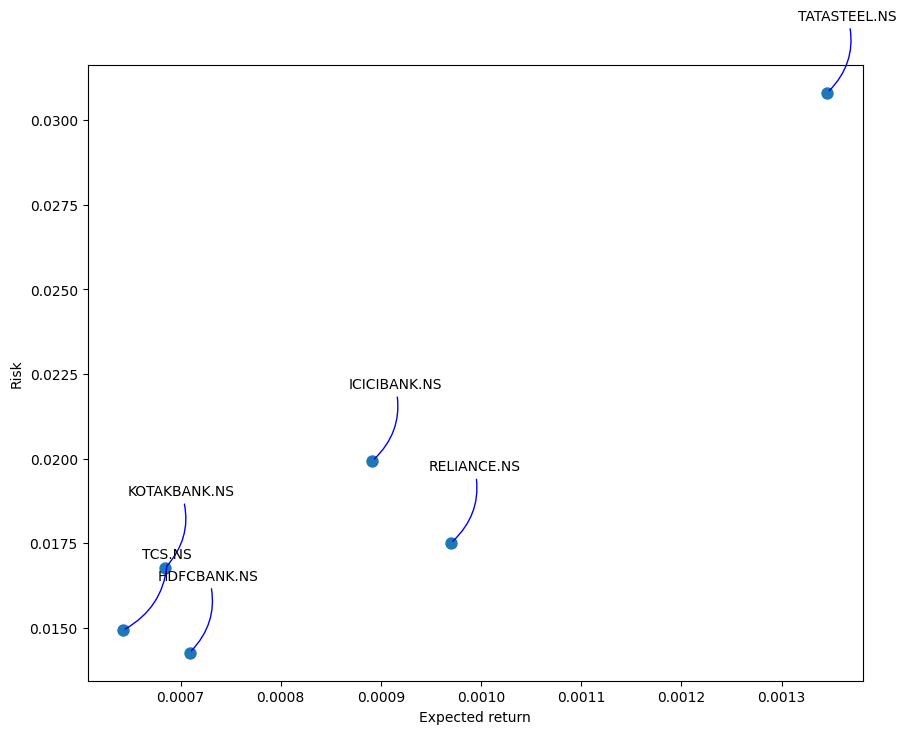

In [ ]:
rets = tech_rets.dropna()
area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

**Preparing the LSTM Model**

In [ ]:
df = yf.download('TATASTEEL.NS', start='2012-01-01', end=datetime.now())
dataset = df['Close'].values.reshape(-1, 1)
training_data_len = int(np.ceil(len(dataset) * 0.95))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[*********************100%***********************]  1 of 1 completed


**Training the LSTM Model**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2923/2923 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.0017
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE: 4.362487980536614


<ipython-input-48-952c0c2d8004>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


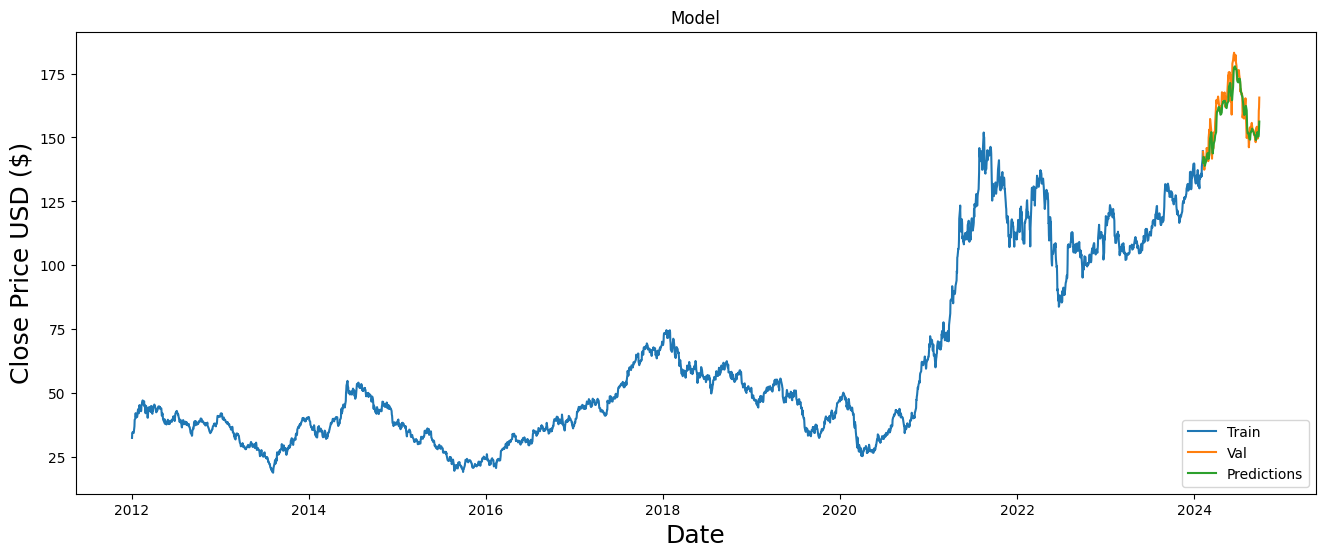

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

print(f'RMSE: {rmse}')

plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0097 - val_loss: 0.0028
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 4.8080e-04
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2606e-04 - val_loss: 0.0025
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.9337e-04 - val_loss: 0.0015
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0524e-04 - val_loss: 5.7178e-04
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.2219e-04 - val_loss: 4.3369e-04
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.6837e-04 - val_loss: 3.5283e-04
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0122e-04 - val_loss: 4.1659e-04
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.6811e-04 - val_loss: 0.0012
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9375e-04 - val_loss: 5.1932e-04
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0766e-04 - val_loss: 3.8559e-04
Epoch 1

<ipython-input-35-78e1291e923b>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


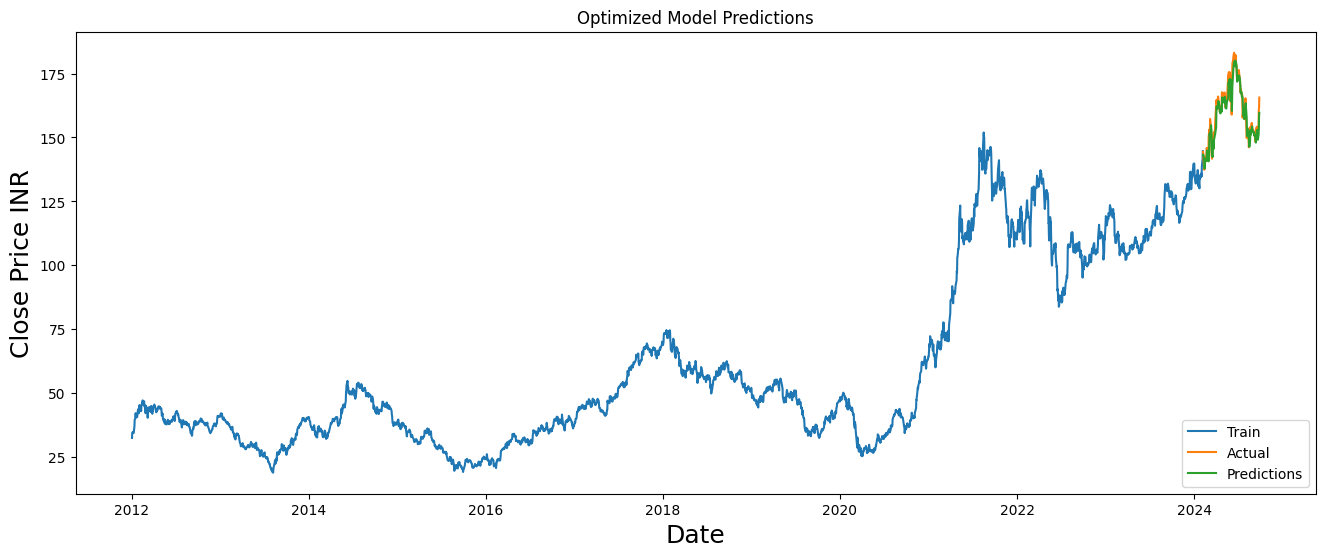

In [ ]:
dataset = df['Close'].values.reshape(-1, 1)
training_data_len = int(np.ceil(len(dataset) * 0.65))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(100, len(train_data)):
    x_train.append(train_data[i-100:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

def build_model(units=128, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units//2, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

model = build_model(units=128, dropout_rate=0.2, learning_rate=0.001)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.1, callbacks=[early_stop])

test_data = scaled_data[training_data_len - 100:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(100, len(test_data)):
    x_test.append(test_data[i-100:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f'Optimized RMSE: {rmse}')
print(f'Optimized MAE: {mae}')
print(f'Optimized MAPE: {mape}%')

train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 6))
plt.title('Optimized Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.plot(train['Close'], label='Training Data')
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()


In [ ]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 10.9 MB/s eta 0:00:00


In [ ]:
!pip install -U transformers peft bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 66.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


**Sentiment Analysis**

In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizerFast
from peft import PeftModel  # 0.5.0

# Load Models
base_model = "NousResearch/Llama-2-13b-hf"
peft_model = "FinGPT/fingpt-sentiment_llama2-13b_lora"
tokenizer = LlamaTokenizerFast.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model = LlamaForCausalLM.from_pretrained(
    base_model,
    trust_remote_code=True,
    device_map="cuda:0",
    load_in_8bit=True,
)
model = PeftModel.from_pretrained(model, peft_model)
model = model.eval()

# Make prompts
prompt = [
    '''Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}
Input: FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .
Answer: ''',
    '''Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}
Input: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Answer: ''',
    '''Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}
Input: A tinyurl link takes users to a scamming site promising that users can earn thousands of dollars by becoming a Google ( NASDAQ : GOOG ) Cash advertiser .
Answer: ''',
]

tokens = tokenizer(prompt, return_tensors='pt', padding=True, max_length=512)
tokens = tokens.to('cuda')

print("Tokenized Input:", tokens)

res = model.generate(**tokens, max_length=512)

print("Raw Output Tokens:", res)

res_sentences = [tokenizer.decode(i, skip_special_tokens=True) for i in res]

print("Decoded Sentences:", res_sentences)

out_text = [o.split("Answer: ")[1].strip() for o in res_sentences]

for sentiment in out_text:
    print(sentiment)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/196 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2855: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Tokenized Input: {'input_ids': tensor([[    1,  2799,  4080, 29901,  1724,   338,   278, 19688,   310,   445,
          9763, 29973,  3529,  6755,   385,  1234,   515,   426, 22198, 29914,
         17821,  1705, 29914,  1066,  3321, 29913,    13,  4290, 29901,   383,
          1177,  2190, 29907,  4214,  8079, 12738, 29949, 21514,   525, 29903,
           402, 25180,  4690, 26562, 29877,  2388,   338,   946,  3663,  3598,
         12359, 26420,   967, 14321, 13705,   491, 10231,   368, 12789,  4746,
           373,  5722,  1189,  1711,   901,  9667,   292,   379,  4571, 13350,
         11369,  1045,  3163,  9609, 29933, 29879,   869,    13, 22550, 29901,
         29871],
        [    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     1,  2799,  4080, 29901,  1724,   338,   278,
         19688,   310,   445,  9763, 29973,  3529,  6755,   385,  1234,   515,
    

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Raw Output Tokens: tensor([[    1,  2799,  4080, 29901,  1724,   338,   278, 19688,   310,   445,
          9763, 29973,  3529,  6755,   385,  1234,   515,   426, 22198, 29914,
         17821,  1705, 29914,  1066,  3321, 29913,    13,  4290, 29901,   383,
          1177,  2190, 29907,  4214,  8079, 12738, 29949, 21514,   525, 29903,
           402, 25180,  4690, 26562, 29877,  2388,   338,   946,  3663,  3598,
         12359, 26420,   967, 14321, 13705,   491, 10231,   368, 12789,  4746,
           373,  5722,  1189,  1711,   901,  9667,   292,   379,  4571, 13350,
         11369,  1045,  3163,  9609, 29933, 29879,   869,    13, 22550, 29901,
         29871,  6374,     2],
        [    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     1,  2799,  4080, 29901,  1724,   338,   278,
         19688,   310,   445,  9763, 29973,  3529,  6755,   385,  1234,   515,
  

**Technical Indicators**

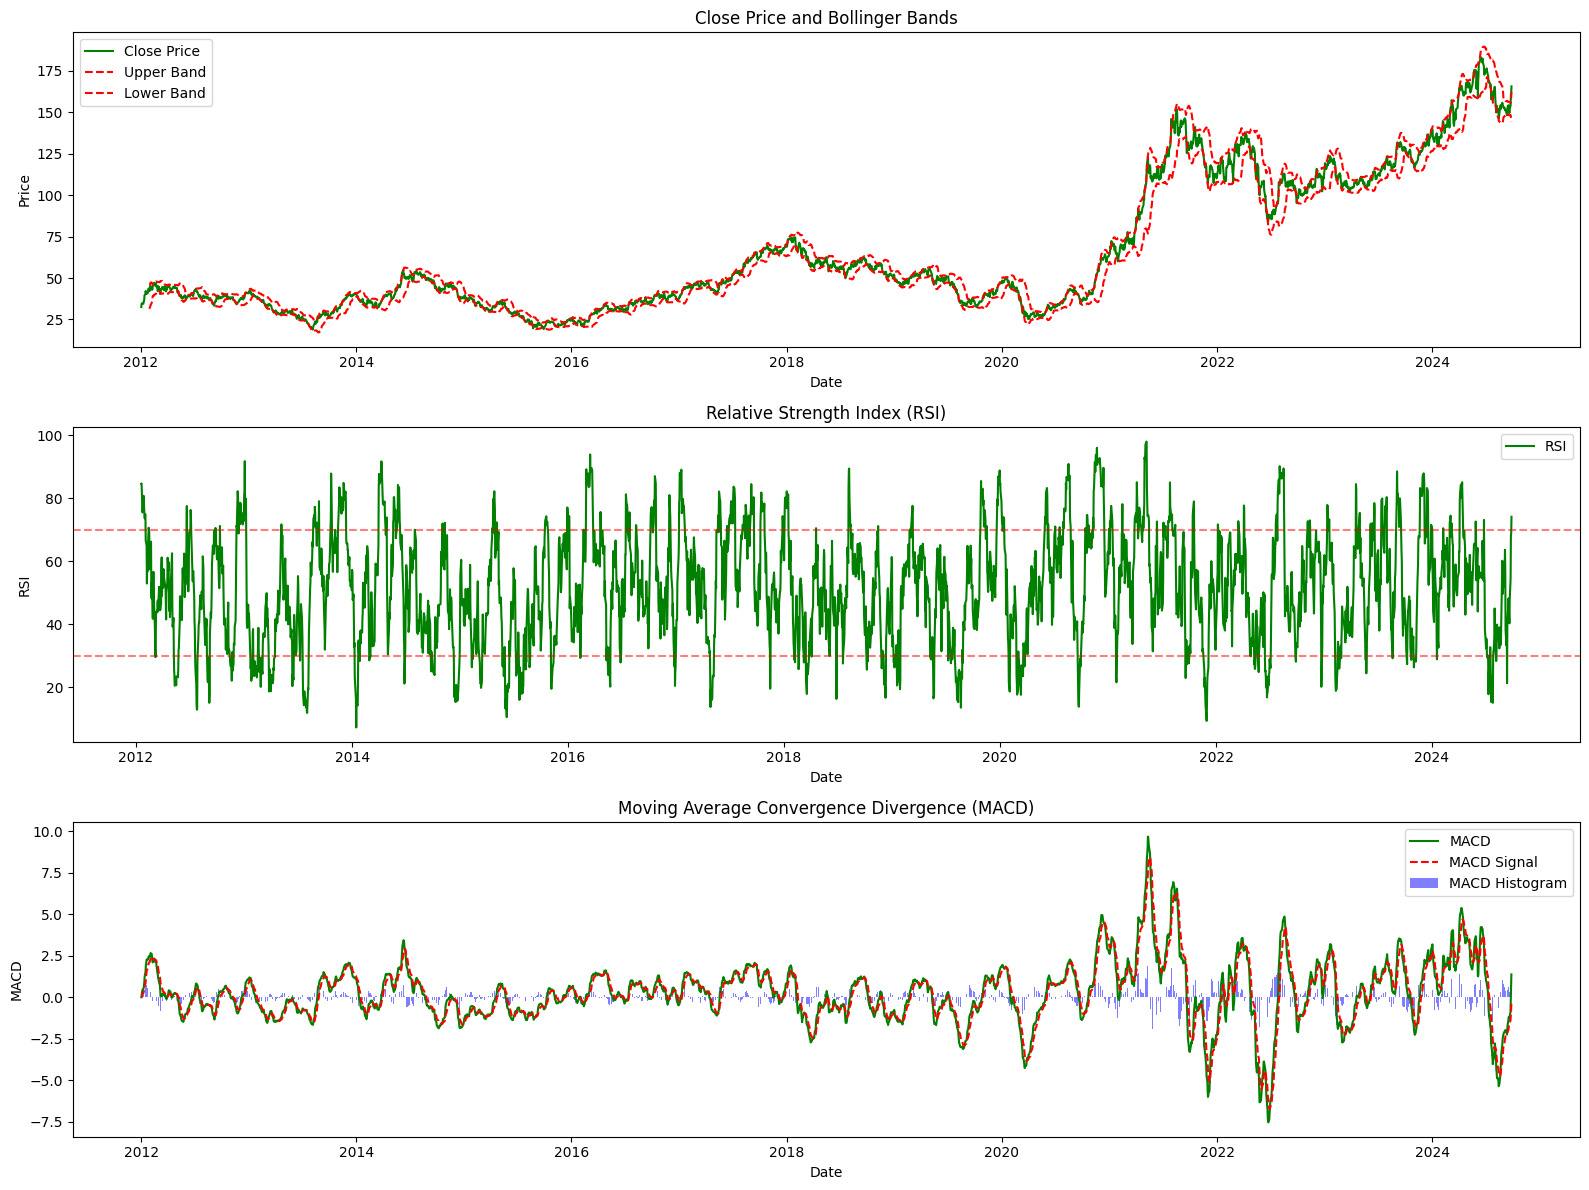

In [ ]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df)

def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std * num_std_dev)
    lower_band = sma - (rolling_std * num_std_dev)
    return upper_band, lower_band

df['Upper Band'], df['Lower Band'] = calculate_bollinger_bands(df)

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    macd_hist = macd - signal
    return macd, signal, macd_hist

df['MACD'], df['MACD Signal'], df['MACD Hist'] = calculate_macd(df)

dataset = df[['Close', 'RSI', 'Upper Band', 'Lower Band', 'MACD', 'MACD Signal', 'MACD Hist']].fillna(0).values

plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.plot(df['Close'], label='Close Price', color='green')
plt.plot(df['Upper Band'], label='Upper Band', color='red', linestyle='dashed')
plt.plot(df['Lower Band'], label='Lower Band', color='red', linestyle='dashed')
plt.title('Close Price and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['RSI'], label='RSI', color='green')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='red')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['MACD'], label='MACD', color='green')
plt.plot(df['MACD Signal'], label='MACD Signal', color='red', linestyle='--')
plt.bar(df.index, df['MACD Hist'], label='MACD Histogram', color='blue', alpha=0.5)
plt.title('Moving Average Convergence Divergence (MACD)')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()

plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


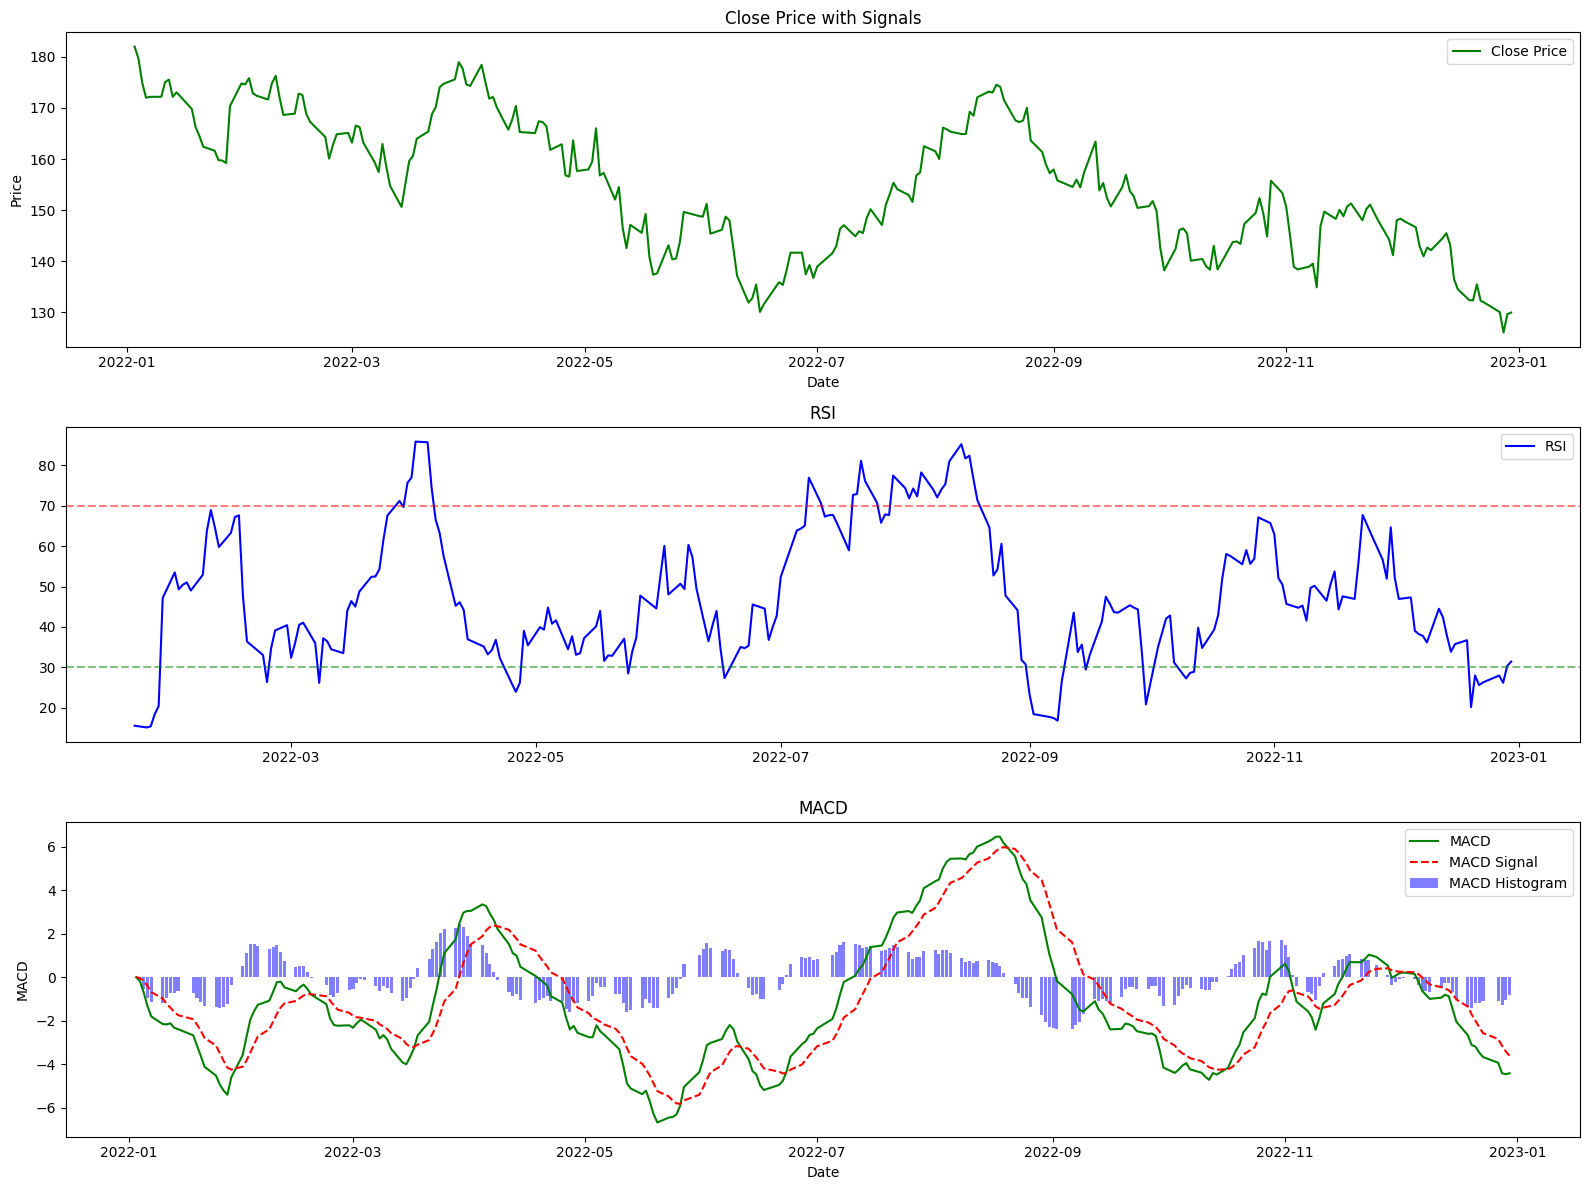

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Fetch stock data from Yahoo Finance
def load_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    return df

# Define the stock ticker and date range
ticker = 'AAPL'  # You can change this to any stock ticker
start_date = '2022-01-01'
end_date = '2023-01-01'

# Load stock data into a DataFrame
df = load_stock_data(ticker, start_date, end_date)

# Technical Indicator Calculation Functions
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std * num_std_dev)
    lower_band = sma - (rolling_std * num_std_dev)
    return upper_band, lower_band

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    macd_hist = macd - signal
    return macd, signal, macd_hist

def calculate_sma(data, window=50):
    return data['Close'].rolling(window=window).mean()

def calculate_ema(data, window=50):
    return data['Close'].ewm(span=window, adjust=False).mean()

def calculate_stochastic(data, window=14):
    low_min = data['Low'].rolling(window=window).min()
    high_max = data['High'].rolling(window=window).max()
    k_percent = 100 * (data['Close'] - low_min) / (high_max - low_min)
    return k_percent

def calculate_adx(data, window=14):
    high_diff = data['High'].diff()
    low_diff = data['Low'].diff()
    plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    tr = np.max([data['High'] - data['Low'], abs(data['High'] - data['Close'].shift(1)), abs(data['Low'] - data['Close'].shift(1))], axis=0)
    atr = pd.Series(tr).rolling(window=window).mean()
    plus_di = 100 * (plus_dm / atr).rolling(window=window).mean()
    minus_di = 100 * (minus_dm / atr).rolling(window=window).mean()
    adx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di)).rolling(window=window).mean()
    return adx

# Feature Engineering
df['RSI'] = calculate_rsi(df)
df['Upper Band'], df['Lower Band'] = calculate_bollinger_bands(df)
df['MACD'], df['MACD Signal'], df['MACD Hist'] = calculate_macd(df)
df['SMA'] = calculate_sma(df)
df['EMA'] = calculate_ema(df)
df['Stochastic'] = calculate_stochastic(df)
df['ADX'] = calculate_adx(df)

# Generate Buy/Sell Signals
def generate_signals(data):
    signals = []
    for index, row in data.iterrows():
        if row['RSI'] < 30 and row['MACD'] > row['MACD Signal'] and row['Close'] < row['Lower Band']:
            signals.append('BUY')
        elif row['RSI'] > 70 and row['MACD'] < row['MACD Signal'] and row['Close'] > row['Upper Band']:
            signals.append('SELL')
        else:
            signals.append('HOLD')
    return signals

df['Signal'] = generate_signals(df)

# Visualization
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(df['Close'], label='Close Price', color='green')
plt.title('Close Price with Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['RSI'], label='RSI', color='blue')
plt.title('RSI')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['MACD'], label='MACD', color='green')
plt.plot(df['MACD Signal'], label='MACD Signal', color='red', linestyle='--')
plt.bar(df.index, df['MACD Hist'], label='MACD Histogram', color='blue', alpha=0.5)
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
pip install pandas-ta


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=0b50a8074dede405512473f52c6bab8237faf8ae7f50b190b79e673418c35557
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


[*********************100%***********************]  1 of 1 completed


Trade Signal: BUY
Price Point: 192.52999877929688


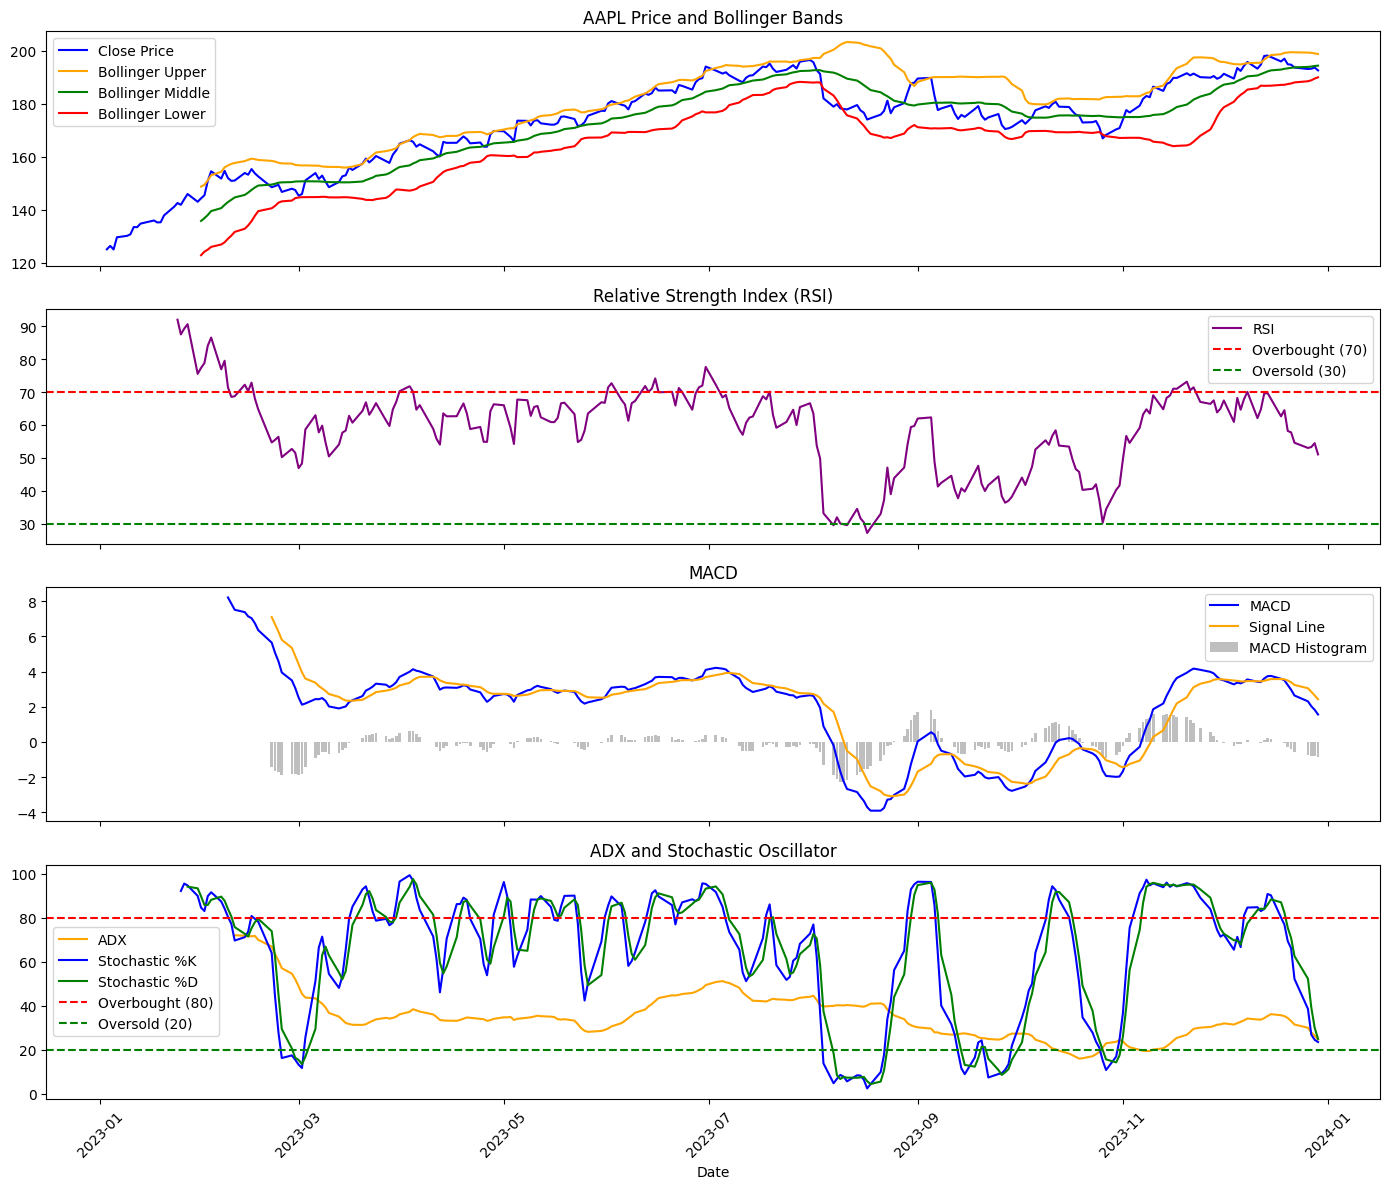

In [ ]:
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Function to generate trade signal based on multiple indicators
def generate_trade_signal(df):
    signals = []

    # RSI
    df['RSI'] = ta.rsi(df['Close'], length=14)
    signals.append((df['RSI'].iloc[-1] > 70, df['RSI'].iloc[-1] < 30))  # Buy if RSI < 30, Sell if RSI > 70

    # Bollinger Bands
    bb = ta.bbands(df['Close'], length=20, std=2)
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = bb['BBU_20_2.0'], bb['BBM_20_2.0'], bb['BBL_20_2.0']
    signals.append((df['Close'].iloc[-1] > df['BB_upper'].iloc[-1], df['Close'].iloc[-1] < df['BB_lower'].iloc[-1]))  # Buy if close < lower, Sell if close > upper

    # MACD
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = macd['MACD_12_26_9'], macd['MACDs_12_26_9'], macd['MACDh_12_26_9']
    signals.append((df['MACD'].iloc[-1] < df['MACD_signal'].iloc[-1], df['MACD'].iloc[-1] > df['MACD_signal'].iloc[-1]))  # Buy if MACD < Signal, Sell if MACD > Signal

    # Stochastic Oscillator
    stoch = ta.stoch(df['High'], df['Low'], df['Close'], k=14, d=3)
    df['STOCH_k'], df['STOCH_d'] = stoch['STOCHk_14_3_3'], stoch['STOCHd_14_3_3']
    signals.append((df['STOCH_k'].iloc[-1] > 80, df['STOCH_k'].iloc[-1] < 20))  # Buy if %K < 20, Sell if %K > 80

    # Moving Averages (SMA and EMA)
    df['SMA_50'] = ta.sma(df['Close'], length=50)
    df['EMA_50'] = ta.ema(df['Close'], length=50)
    signals.append((df['Close'].iloc[-1] > df['SMA_50'].iloc[-1], df['Close'].iloc[-1] < df['SMA_50'].iloc[-1]))  # Buy if close > SMA, Sell if close < SMA
    signals.append((df['Close'].iloc[-1] > df['EMA_50'].iloc[-1], df['Close'].iloc[-1] < df['EMA_50'].iloc[-1]))  # Buy if close > EMA, Sell if close < EMA

    # ADX
    adx = ta.adx(df['High'], df['Low'], df['Close'], length=14)
    df['ADX'], df['ADX_plus'], df['ADX_minus'] = adx['ADX_14'], adx['DMP_14'], adx['DMN_14']
    signals.append((df['ADX'].iloc[-1] > 25, df['ADX'].iloc[-1] < 25))  # Strong trend signal if ADX > 25

    # Parabolic SAR (Proper handling)
    psar = ta.psar(df['High'], df['Low'], df['Close'], af=0.02, max_af=0.2)
    df['PSAR'] = psar['PSARl_0.02_0.2']
    signals.append((df['Close'].iloc[-1] > df['PSAR'].iloc[-1], df['Close'].iloc[-1] < df['PSAR'].iloc[-1]))  # Buy if close > PSAR, Sell if close < PSAR

    # CCI
    df['CCI'] = ta.cci(df['High'], df['Low'], df['Close'], length=20)
    signals.append((df['CCI'].iloc[-1] > 100, df['CCI'].iloc[-1] < -100))  # Buy if CCI < -100, Sell if CCI > 100

    # Volume Weighted Average Price (VWAP)
    df['VWAP'] = ta.vwap(df['High'], df['Low'], df['Close'], df['Volume'])
    signals.append((df['Close'].iloc[-1] > df['VWAP'].iloc[-1], df['Close'].iloc[-1] < df['VWAP'].iloc[-1]))  # Buy if close > VWAP, Sell if close < VWAP

    # Majority Vote
    buy_signals = sum([buy for buy, sell in signals])
    sell_signals = sum([sell for buy, sell in signals])

    if buy_signals > sell_signals:
        return "BUY", df['Close'].iloc[-1]
    elif sell_signals > buy_signals:
        return "SELL", df['Close'].iloc[-1]
    else:
        return "HOLD", df['Close'].iloc[-1]

# Fetch historical data using yfinance
ticker = "AAPL"
df = yf.download(ticker, start="2023-01-01", end="2024-01-01")

# Apply technical indicators and generate trade signal
trade_signal, price = generate_trade_signal(df)

# Display the final trade signal and price point
print(f"Trade Signal: {trade_signal}")
print(f"Price Point: {price}")

# Plotting technical indicators
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Plot Close Price and Bollinger Bands
axs[0].plot(df['Close'], label='Close Price', color='blue')
axs[0].plot(df['BB_upper'], label='Bollinger Upper', color='orange')
axs[0].plot(df['BB_middle'], label='Bollinger Middle', color='green')
axs[0].plot(df['BB_lower'], label='Bollinger Lower', color='red')
axs[0].set_title(f"{ticker} Price and Bollinger Bands")
axs[0].legend()

# Plot RSI
axs[1].plot(df['RSI'], label='RSI', color='purple')
axs[1].axhline(70, linestyle='--', color='red', label='Overbought (70)')
axs[1].axhline(30, linestyle='--', color='green', label='Oversold (30)')
axs[1].set_title('Relative Strength Index (RSI)')
axs[1].legend()

# Plot MACD
axs[2].plot(df['MACD'], label='MACD', color='blue')
axs[2].plot(df['MACD_signal'], label='Signal Line', color='orange')
axs[2].bar(df.index, df['MACD_hist'], label='MACD Histogram', color='grey', alpha=0.5)
axs[2].set_title('MACD')
axs[2].legend()

# Plot ADX and Stochastic
axs[3].plot(df['ADX'], label='ADX', color='orange')
axs[3].plot(df['STOCH_k'], label='Stochastic %K', color='blue')
axs[3].plot(df['STOCH_d'], label='Stochastic %D', color='green')
axs[3].axhline(80, linestyle='--', color='red', label='Overbought (80)')
axs[3].axhline(20, linestyle='--', color='green', label='Oversold (20)')
axs[3].set_title('ADX and Stochastic Oscillator')
axs[3].legend()

# Set x-axis label for all subplots
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


Trade Signal: BUY
Price Point: 192.52999877929688


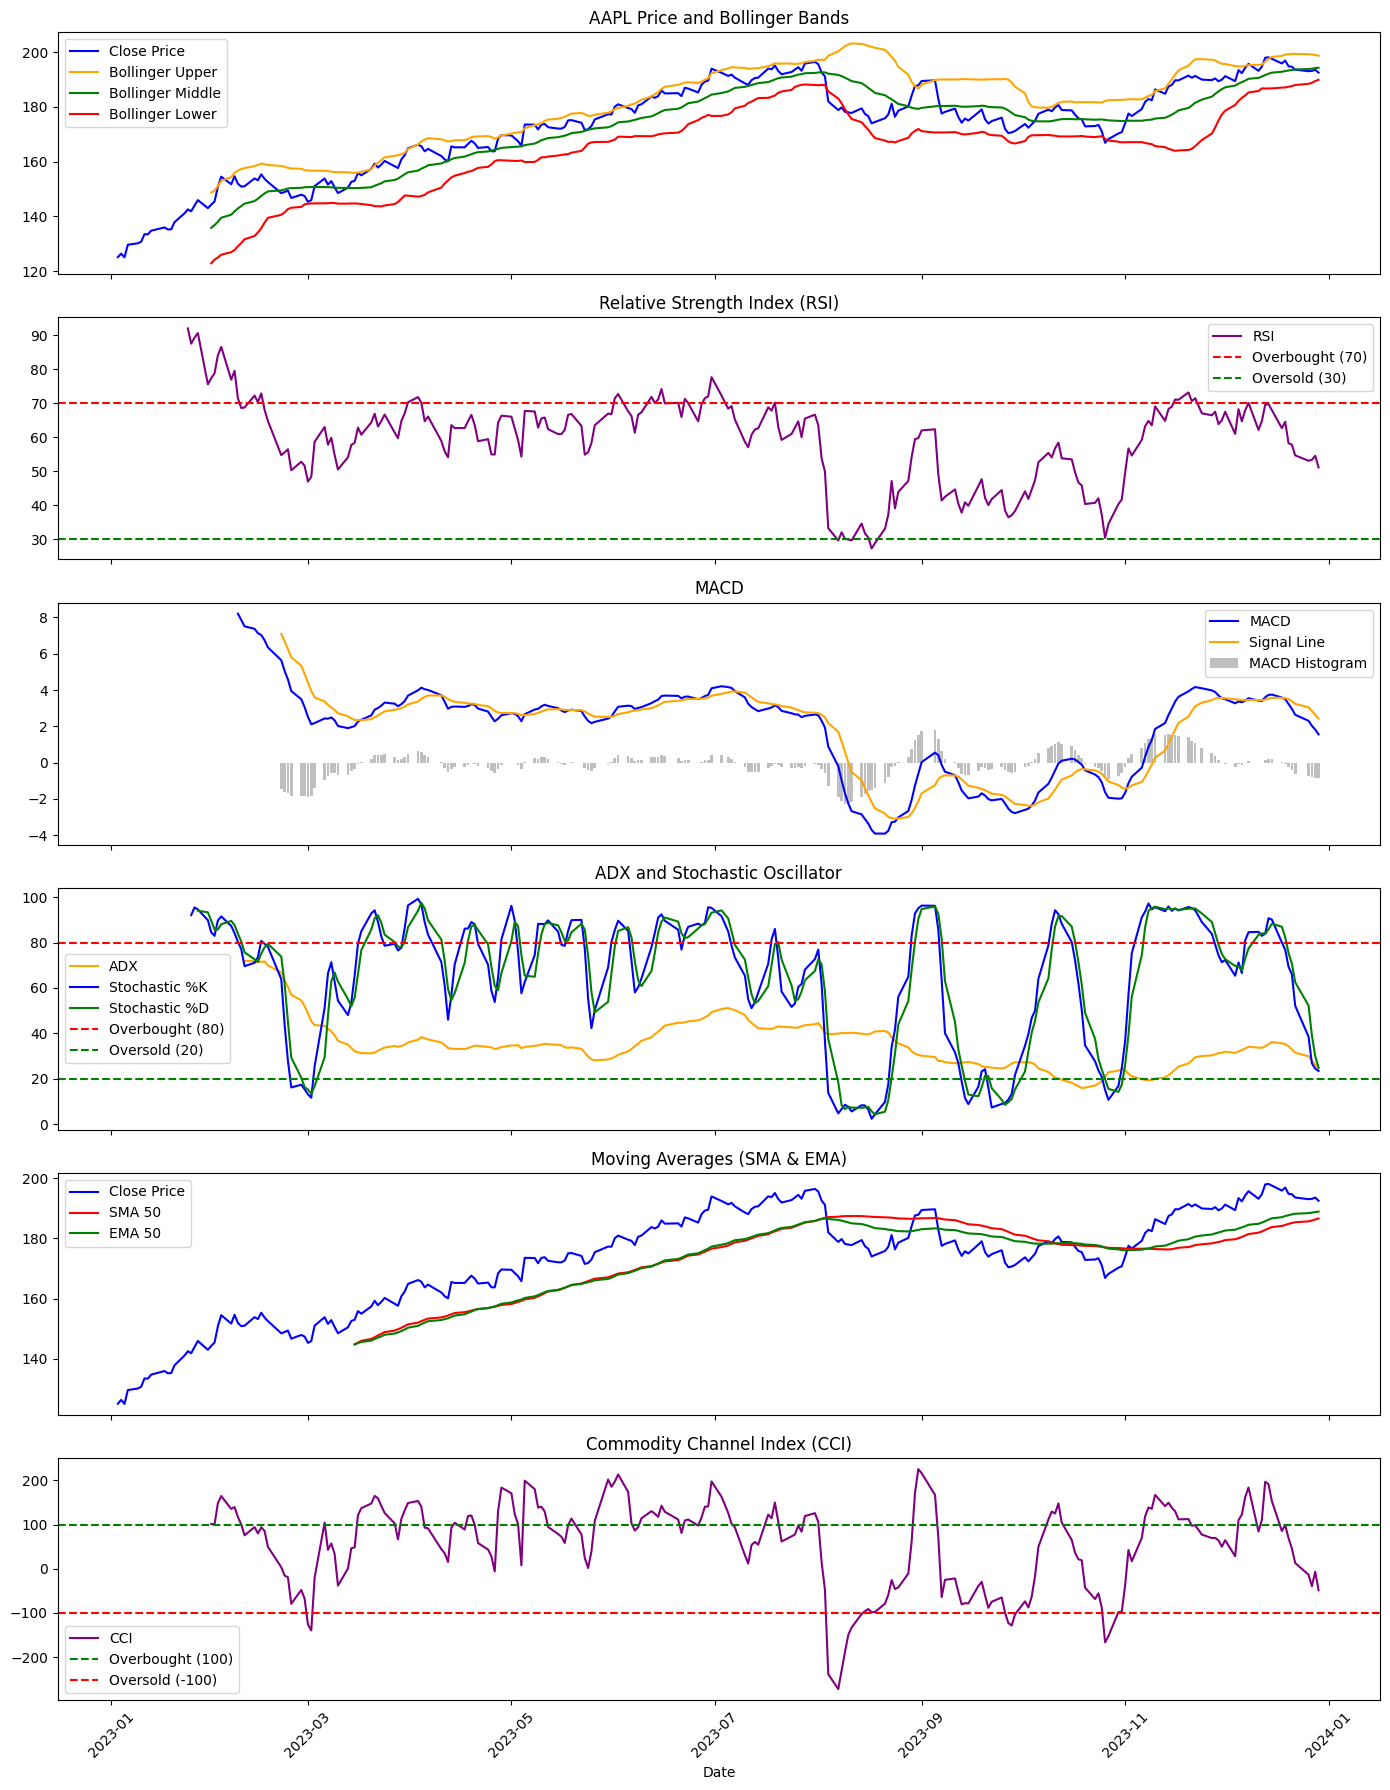

In [ ]:
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import matplotlib.pyplot as plt

# Function to generate trade signal based on multiple indicators
def generate_trade_signal(df):
    signals = []

    # RSI
    df['RSI'] = ta.rsi(df['Close'], length=14)
    signals.append((df['RSI'].iloc[-1] > 70, df['RSI'].iloc[-1] < 30))  # Buy if RSI < 30, Sell if RSI > 70

    # Bollinger Bands
    bb = ta.bbands(df['Close'], length=20, std=2)
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = bb['BBU_20_2.0'], bb['BBM_20_2.0'], bb['BBL_20_2.0']
    signals.append((df['Close'].iloc[-1] > df['BB_upper'].iloc[-1], df['Close'].iloc[-1] < df['BB_lower'].iloc[-1]))

    # MACD
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = macd['MACD_12_26_9'], macd['MACDs_12_26_9'], macd['MACDh_12_26_9']
    signals.append((df['MACD'].iloc[-1] < df['MACD_signal'].iloc[-1], df['MACD'].iloc[-1] > df['MACD_signal'].iloc[-1]))

    # Stochastic Oscillator
    stoch = ta.stoch(df['High'], df['Low'], df['Close'], k=14, d=3)
    df['STOCH_k'], df['STOCH_d'] = stoch['STOCHk_14_3_3'], stoch['STOCHd_14_3_3']
    signals.append((df['STOCH_k'].iloc[-1] > 80, df['STOCH_k'].iloc[-1] < 20))

    # Moving Averages (SMA and EMA)
    df['SMA_50'] = ta.sma(df['Close'], length=50)
    df['EMA_50'] = ta.ema(df['Close'], length=50)
    signals.append((df['Close'].iloc[-1] > df['SMA_50'].iloc[-1], df['Close'].iloc[-1] < df['SMA_50'].iloc[-1]))
    signals.append((df['Close'].iloc[-1] > df['EMA_50'].iloc[-1], df['Close'].iloc[-1] < df['EMA_50'].iloc[-1]))

    # ADX
    adx = ta.adx(df['High'], df['Low'], df['Close'], length=14)
    df['ADX'], df['ADX_plus'], df['ADX_minus'] = adx['ADX_14'], adx['DMP_14'], adx['DMN_14']
    signals.append((df['ADX'].iloc[-1] > 25, df['ADX'].iloc[-1] < 25))

    # Parabolic SAR
    psar = ta.psar(df['High'], df['Low'], df['Close'], af=0.02, max_af=0.2)
    df['PSAR'] = psar['PSARl_0.02_0.2']
    signals.append((df['Close'].iloc[-1] > df['PSAR'].iloc[-1], df['Close'].iloc[-1] < df['PSAR'].iloc[-1]))

    # CCI
    df['CCI'] = ta.cci(df['High'], df['Low'], df['Close'], length=20)
    signals.append((df['CCI'].iloc[-1] > 100, df['CCI'].iloc[-1] < -100))

    # VWAP
    df['VWAP'] = ta.vwap(df['High'], df['Low'], df['Close'], df['Volume'])
    signals.append((df['Close'].iloc[-1] > df['VWAP'].iloc[-1], df['Close'].iloc[-1] < df['VWAP'].iloc[-1]))

    # Majority Vote
    buy_signals = sum([buy for buy, sell in signals])
    sell_signals = sum([sell for buy, sell in signals])

    if buy_signals > sell_signals:
        return "BUY", df['Close'].iloc[-1]
    elif sell_signals > buy_signals:
        return "SELL", df['Close'].iloc[-1]
    else:
        return "HOLD", df['Close'].iloc[-1]

# Fetch historical data using yfinance
ticker = "AAPL"
df = yf.download(ticker, start="2023-01-01", end="2024-01-01")

# Apply technical indicators and generate trade signal
trade_signal, price = generate_trade_signal(df)

# Display the final trade signal and price point
print(f"Trade Signal: {trade_signal}")
print(f"Price Point: {price}")

# Plotting technical indicators
fig, axs = plt.subplots(6, 1, figsize=(14, 18), sharex=True)

# Plot Close Price and Bollinger Bands
axs[0].plot(df['Close'], label='Close Price', color='blue')
axs[0].plot(df['BB_upper'], label='Bollinger Upper', color='orange')
axs[0].plot(df['BB_middle'], label='Bollinger Middle', color='green')
axs[0].plot(df['BB_lower'], label='Bollinger Lower', color='red')
axs[0].set_title(f"{ticker} Price and Bollinger Bands")
axs[0].legend()

# Plot RSI
axs[1].plot(df['RSI'], label='RSI', color='purple')
axs[1].axhline(70, linestyle='--', color='red', label='Overbought (70)')
axs[1].axhline(30, linestyle='--', color='green', label='Oversold (30)')
axs[1].set_title('Relative Strength Index (RSI)')
axs[1].legend()

# Plot MACD
axs[2].plot(df['MACD'], label='MACD', color='blue')
axs[2].plot(df['MACD_signal'], label='Signal Line', color='orange')
axs[2].bar(df.index, df['MACD_hist'], label='MACD Histogram', color='grey', alpha=0.5)
axs[2].set_title('MACD')
axs[2].legend()

# Plot ADX and Stochastic
axs[3].plot(df['ADX'], label='ADX', color='orange')
axs[3].plot(df['STOCH_k'], label='Stochastic %K', color='blue')
axs[3].plot(df['STOCH_d'], label='Stochastic %D', color='green')
axs[3].axhline(80, linestyle='--', color='red', label='Overbought (80)')
axs[3].axhline(20, linestyle='--', color='green', label='Oversold (20)')
axs[3].set_title('ADX and Stochastic Oscillator')
axs[3].legend()

# Plot Moving Averages
axs[4].plot(df['Close'], label='Close Price', color='blue')
axs[4].plot(df['SMA_50'], label='SMA 50', color='red')
axs[4].plot(df['EMA_50'], label='EMA 50', color='green')
axs[4].set_title('Moving Averages (SMA & EMA)')
axs[4].legend()

# Plot CCI and VWAP
axs[5].plot(df['CCI'], label='CCI', color='purple')
axs[5].axhline(100, linestyle='--', color='green', label='Overbought (100)')
axs[5].axhline(-100, linestyle='--', color='red', label='Oversold (-100)')
axs[5].set_title('Commodity Channel Index (CCI)')
axs[5].legend()

# Set x-axis label for all subplots
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


Trade Signal: BUY
Price Point: 192.52999877929688


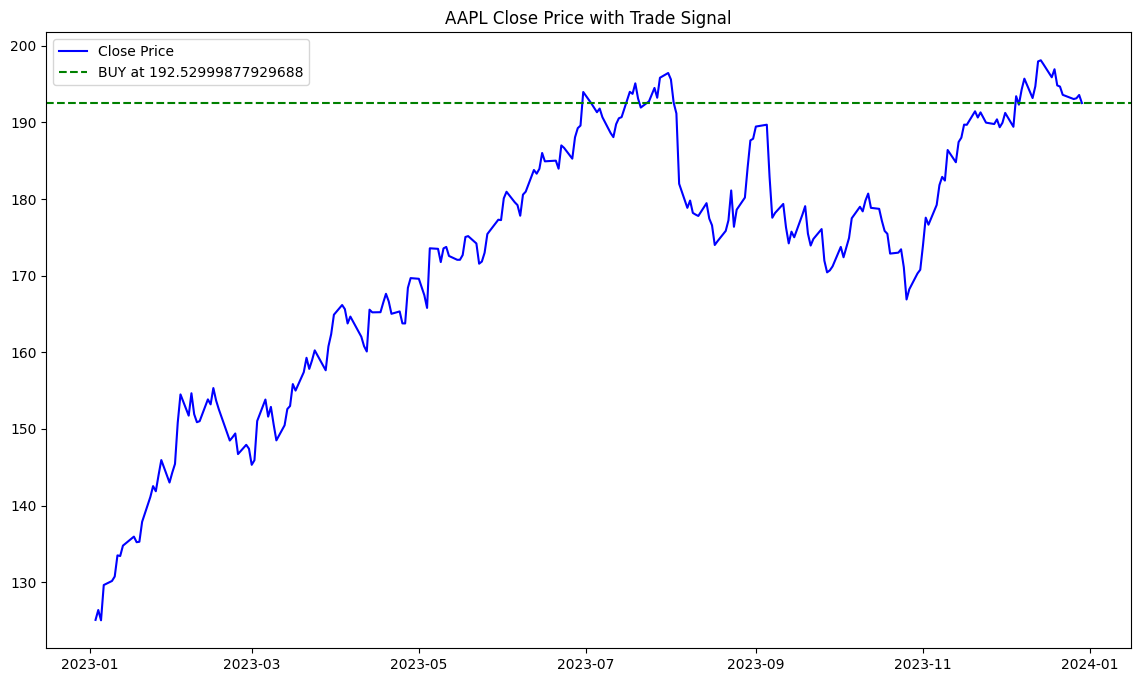

In [ ]:
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import matplotlib.pyplot as plt

# Function to generate trade signal based on multiple indicators
def generate_trade_signal(df):
    signals = []

    # RSI
    df['RSI'] = ta.rsi(df['Close'], length=14)
    signals.append((df['RSI'].iloc[-1] > 70, df['RSI'].iloc[-1] < 30))  # Buy if RSI < 30, Sell if RSI > 70

    # Bollinger Bands
    bb = ta.bbands(df['Close'], length=20, std=2)
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = bb['BBU_20_2.0'], bb['BBM_20_2.0'], bb['BBL_20_2.0']
    signals.append((df['Close'].iloc[-1] > df['BB_upper'].iloc[-1], df['Close'].iloc[-1] < df['BB_lower'].iloc[-1]))  # Buy if close < lower, Sell if close > upper

    # MACD
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = macd['MACD_12_26_9'], macd['MACDs_12_26_9'], macd['MACDh_12_26_9']
    signals.append((df['MACD'].iloc[-1] < df['MACD_signal'].iloc[-1], df['MACD'].iloc[-1] > df['MACD_signal'].iloc[-1]))  # Buy if MACD < Signal, Sell if MACD > Signal

    # Stochastic Oscillator
    stoch = ta.stoch(df['High'], df['Low'], df['Close'], k=14, d=3)
    df['STOCH_k'], df['STOCH_d'] = stoch['STOCHk_14_3_3'], stoch['STOCHd_14_3_3']
    signals.append((df['STOCH_k'].iloc[-1] > 80, df['STOCH_k'].iloc[-1] < 20))  # Buy if %K < 20, Sell if %K > 80

    # Moving Averages (SMA and EMA)
    df['SMA_50'] = ta.sma(df['Close'], length=50)
    df['EMA_50'] = ta.ema(df['Close'], length=50)
    signals.append((df['Close'].iloc[-1] > df['SMA_50'].iloc[-1], df['Close'].iloc[-1] < df['SMA_50'].iloc[-1]))  # Buy if close > SMA, Sell if close < SMA
    signals.append((df['Close'].iloc[-1] > df['EMA_50'].iloc[-1], df['Close'].iloc[-1] < df['EMA_50'].iloc[-1]))  # Buy if close > EMA, Sell if close < EMA

    # ADX
    adx = ta.adx(df['High'], df['Low'], df['Close'], length=14)
    df['ADX'], df['ADX_plus'], df['ADX_minus'] = adx['ADX_14'], adx['DMP_14'], adx['DMN_14']
    signals.append((df['ADX'].iloc[-1] > 25, df['ADX'].iloc[-1] < 25))  # Strong trend signal if ADX > 25

    # Parabolic SAR (Proper handling)
    psar = ta.psar(df['High'], df['Low'], df['Close'], af=0.02, max_af=0.2)
    df['PSAR'], df['PSARaf'], df['PSARr'] = psar['PSARl_0.02_0.2'], psar['PSARaf_0.02_0.2'], psar['PSARr_0.02_0.2']
    signals.append((df['Close'].iloc[-1] > df['PSAR'].iloc[-1], df['Close'].iloc[-1] < df['PSAR'].iloc[-1]))  # Buy if close > PSAR, Sell if close < PSAR

    # CCI
    df['CCI'] = ta.cci(df['High'], df['Low'], df['Close'], length=20)
    signals.append((df['CCI'].iloc[-1] > 100, df['CCI'].iloc[-1] < -100))  # Buy if CCI < -100, Sell if CCI > 100

    # Volume Weighted Average Price (VWAP)
    df['VWAP'] = ta.vwap(df['High'], df['Low'], df['Close'], df['Volume'])
    signals.append((df['Close'].iloc[-1] > df['VWAP'].iloc[-1], df['Close'].iloc[-1] < df['VWAP'].iloc[-1]))  # Buy if close > VWAP, Sell if close < VWAP

    # Majority Vote
    buy_signals = sum([buy for buy, sell in signals])
    sell_signals = sum([sell for buy, sell in signals])

    if buy_signals > sell_signals:
        return "BUY", df['Close'].iloc[-1]
    elif sell_signals > buy_signals:
        return "SELL", df['Close'].iloc[-1]
    else:
        return "HOLD", df['Close'].iloc[-1]

# Fetch historical data using yfinance
ticker = "AAPL"
df = yf.download(ticker, start="2023-01-01", end="2024-01-01")

# Apply technical indicators and generate trade signal
trade_signal, price = generate_trade_signal(df)

# Display the final trade signal and price point
print(f"Trade Signal: {trade_signal}")
print(f"Price Point: {price}")

# Plotting example (optional)
plt.figure(figsize=(14, 8))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title(f"{ticker} Close Price with Trade Signal")
plt.axhline(price, color='green' if trade_signal == 'BUY' else 'red', linestyle='--', label=f"{trade_signal} at {price}")
plt.legend()
plt.show()


In [ ]:
# Backtesting function
def backtest_strategy(df):
    initial_capital = 10000  # Starting capital
    shares = 0  # Number of shares held
    cash = initial_capital  # Cash available
    trade_history = []  # To record trade details

    # Iterate over DataFrame rows to simulate trading
    for index, row in df.iterrows():
        # Generate trade signal
        signal, _ = generate_trade_signal(df[:index + 1])  # Pass only data up to the current index

        if signal == "BUY" and cash >= row['Close']:  # Buy condition
            shares += cash // row['Close']  # Buy as many shares as possible
            cash -= shares * row['Close']  # Deduct the cash used for buying
            trade_history.append({'Action': 'BUY', 'Price': row['Close'], 'Shares': shares, 'Cash Remaining': cash})

        elif signal == "SELL" and shares > 0:  # Sell condition
            cash += shares * row['Close']  # Sell all shares
            trade_history.append({'Action': 'SELL', 'Price': row['Close'], 'Shares': shares, 'Cash Remaining': cash})
            shares = 0  # Reset shares to zero

    # Calculate final portfolio value
    final_value = cash + (shares * df['Close'].iloc[-1])  # Cash + value of remaining shares
    total_return = (final_value - initial_capital) / initial_capital * 100  # Total return in percentage

    return final_value, total_return, trade_history

# Backtest the strategy
final_value, total_return, trade_history = backtest_strategy(df)

# Display results
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")
print("Trade History:")
for trade in trade_history:
    print(trade)


TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [ ]:

pip install --upgrade backtrader


In [ ]:
import backtrader as bt
import yfinance as yf

class HighRiskStrategy(bt.Strategy):
    params = (
        ('rsi_period', 14),
        ('bb_length', 20),
        ('macd_fast', 12),
        ('macd_slow', 26),
        ('macd_signal', 9),
        ('stoch_k', 14),
        ('stoch_d', 3),
        ('stop_loss', 0.02),  # 2% stop loss
        ('take_profit', 0.05),  # 5% take profit
    )

    def __init__(self):
        # Indicators
        self.rsi = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_period)
        self.boll = bt.indicators.BollingerBands(period=self.params.bb_length)
        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.params.macd_fast,
            period_me2=self.params.macd_slow,
            period_signal=self.params.macd_signal
        )

        # Stochastic Indicator
        self.stoch = bt.indicators.Stochastic(
            self.data,
            period=self.params.stoch_k,
            period_d=self.params.stoch_d  # Correctly define the period_d inside the initialization
        )

    def next(self):
        # Buy signal
        if not self.position:  # If no position
            if (self.rsi < 30 and
                self.data.close < self.boll.lines.bot and
                self.macd.macd > self.macd.signal and
                self.stoch.percK < 20):
                self.buy(size=10)  # Aggressive buying
                print(f"BUY at {self.data.close[0]}")

        # Sell signal
        else:
            if (self.rsi > 70 or
                self.data.close > self.boll.lines.top or
                self.macd.macd < self.macd.signal or
                self.stoch.percK > 80):
                self.sell(size=10)  # Aggressive selling
                print(f"SELL at {self.data.close[0]}")

# Backtest function
def run_backtest(ticker):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(HighRiskStrategy)

    # Fetch data from Yahoo Finance
    data = bt.feeds.PandasData(dataname=yf.download(ticker, start="2012-01-01", end="2024-01-01"))
    cerebro.adddata(data)

    cerebro.broker.setcash(100000)  # Starting portfolio value
    print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')

    # Run backtest
    cerebro.run()

    # Print results
    final_value = cerebro.broker.getvalue()
    print(f'Final Portfolio Value: {final_value:.2f}')

    # Analyze trades
    trades = cerebro.getbroker().orders  # Get all orders for analysis
    num_trades = len(trades)

    winning_trades = sum(1 for order in trades if order.status in [bt.Order.Completed] and order.pnl > 0)
    losing_trades = sum(1 for order in trades if order.status in [bt.Order.Completed] and order.pnl < 0)

    print(f'Number of Trades Executed: {num_trades}')
    print(f'Winning Trades: {winning_trades}')
    print(f'Losing Trades: {losing_trades}')

    # Performance metrics
    total_return = (final_value - 100000) / 100000 * 100
    print(f'Total Return: {total_return:.2f}%')

# Run backtest for a volatile stock
if __name__ == "__main__":
    run_backtest('TSLA')  # Example: Tesla for high volatility


[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value: 100000


TypeError: Stochastic.__init__() got an unexpected keyword argument 'period_d'

[*********************100%***********************]  1 of 1 completed


Initial Capital: INR 100000
Final Portfolio Value: INR 188461.79943847656
Total Return: 88.46%
        Date Action  Shares        Price        Capital
0 2020-03-26    Buy   102.0   974.861511     564.125854
1 2020-06-02   Sell   102.0  1417.450562  145144.083130
2 2020-11-26    Buy    80.0  1802.249146     964.151489
3 2021-03-15   Sell    80.0  1946.514038  156685.274536
4 2021-12-30    Buy    71.0  2177.448486    2086.432007
5 2022-04-08   Sell    71.0  2414.244141  173497.765991
6 2022-05-23    Buy    72.0  2406.167969     253.672241
7 2022-08-29   Sell    72.0  2397.630127  172883.041382
8 2022-10-10    Buy    77.0  2220.552734    1900.480835
9 2022-12-13   Sell    77.0  2422.874268  188461.799438


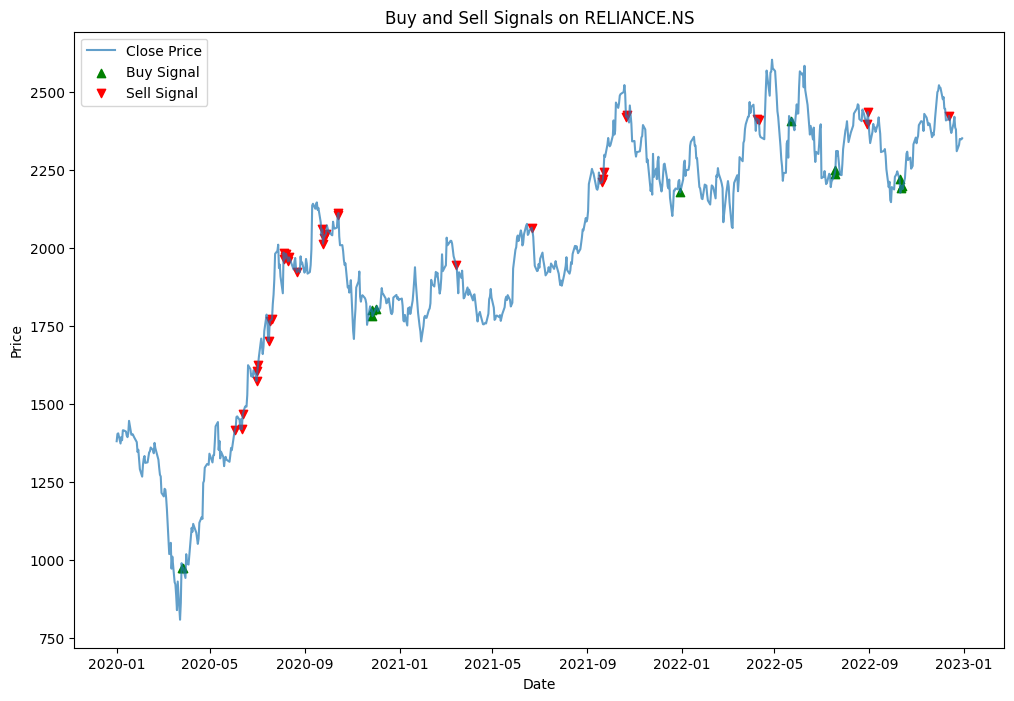

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical data for a stock
ticker = "RELIANCE.NS"  # Example ticker for Reliance Industries (change as needed)
df = yf.download(ticker, start="2020-01-01", end="2023-01-01")

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df, 14)

# Calculate Bollinger Bands
df['20_SMA'] = df['Close'].rolling(window=20).mean()
df['Std_Dev'] = df['Close'].rolling(window=20).std()
df['Upper Band'] = df['20_SMA'] + (2 * df['Std_Dev'])
df['Lower Band'] = df['20_SMA'] - (2 * df['Std_Dev'])

# Calculate MACD
df['12_EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
df['26_EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['12_EMA'] - df['26_EMA']
df['MACD Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Define buy/sell signals based on the relaxed conditions
df['Buy_Signal'] = ((df['RSI'] < 40) & (df['MACD'] > df['MACD Signal'])).astype(int)
df['Sell_Signal'] = ((df['RSI'] > 60) & (df['MACD'] < df['MACD Signal'])).astype(int)

# Initial parameters for backtest
initial_capital = 100000  # INR
shares = 0
capital = initial_capital
portfolio = []

# Backtesting logic
for i in range(1, len(df)):
    if df['Buy_Signal'].iloc[i] == 1 and shares == 0:  # Buy if no shares
        shares = capital // df['Close'].iloc[i]
        capital -= shares * df['Close'].iloc[i]
        portfolio.append({'Date': df.index[i], 'Action': 'Buy', 'Shares': shares, 'Price': df['Close'].iloc[i], 'Capital': capital})
    elif df['Sell_Signal'].iloc[i] == 1 and shares > 0:  # Sell if shares held
        capital += shares * df['Close'].iloc[i]
        portfolio.append({'Date': df.index[i], 'Action': 'Sell', 'Shares': shares, 'Price': df['Close'].iloc[i], 'Capital': capital})
        shares = 0

# If still holding shares at the end, sell them
if shares > 0:
    capital += shares * df['Close'].iloc[-1]
    portfolio.append({'Date': df.index[-1], 'Action': 'Sell', 'Shares': shares, 'Price': df['Close'].iloc[-1], 'Capital': capital})

# Create a DataFrame to store portfolio transactions
portfolio_df = pd.DataFrame(portfolio, columns=['Date', 'Action', 'Shares', 'Price', 'Capital'])

# Calculate returns
final_value = capital
total_return = (final_value - initial_capital) / initial_capital * 100

# Output the results
print(f"Initial Capital: INR {initial_capital}")
print(f"Final Portfolio Value: INR {final_value}")
print(f"Total Return: {total_return:.2f}%")
print(portfolio_df)

# Plot Buy/Sell signals along with closing price
plt.figure(figsize=(12,8))
plt.plot(df['Close'], label='Close Price', alpha=0.7)
plt.scatter(df.index[df['Buy_Signal'] == 1], df['Close'][df['Buy_Signal'] == 1], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(df.index[df['Sell_Signal'] == 1], df['Close'][df['Sell_Signal'] == 1], marker='v', color='r', label='Sell Signal', alpha=1)
plt.title(f"Buy and Sell Signals on {ticker}")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Parameters
INITIAL_CAPITAL = 100000
STOP_LOSS_PERCENTAGE = 0.03  # 3% stop loss
MAX_DRAWDOWN_PERCENTAGE = 0.10  # 10% max drawdown
RSI_PERIOD = 14
MACD_FAST_PERIOD = 12
MACD_SLOW_PERIOD = 26
MACD_SIGNAL_PERIOD = 9

# Download historical stock data
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Calculate RSI
def compute_rsi(data, period=RSI_PERIOD):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate MACD
def compute_macd(data, fast_period=MACD_FAST_PERIOD, slow_period=MACD_SLOW_PERIOD, signal_period=MACD_SIGNAL_PERIOD):
    exp1 = data['Close'].ewm(span=fast_period, adjust=False).mean()
    exp2 = data['Close'].ewm(span=slow_period, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

# Trading Strategy
def trading_strategy(data):
    # Compute indicators
    data['RSI'] = compute_rsi(data)
    data['MACD'], data['Signal'] = compute_macd(data)

    # Signals
    data['Buy_Signal'] = ((data['RSI'] < 40) & (data['MACD'] > data['Signal'])).astype(int)
    data['Sell_Signal'] = ((data['RSI'] > 60) & (data['MACD'] < data['Signal'])).astype(int)

    # Positioning
    data['Position'] = 0
    data['Position'] = np.where(data['Buy_Signal'] == 1, 1, data['Position'])
    data['Position'] = np.where(data['Sell_Signal'] == 1, -1, data['Position'])
    data['Position'] = data['Position'].replace(to_replace=0, method='ffill', limit=1)  # Forward fill once

    # Calculate daily returns
    data['Daily_Return'] = data['Close'].pct_change() * data['Position'].shift(1)

    return data

# Backtest the strategy
def backtest_strategy(data):
    data['Portfolio_Value'] = INITIAL_CAPITAL * (1 + data['Daily_Return']).cumprod()
    data['Drawdown'] = data['Portfolio_Value'] / data['Portfolio_Value'].cummax() - 1
    data['Max_Drawdown'] = data['Drawdown'].min()

    return data

# Main function to run the code
def main(ticker):
    start_date = "2020-01-01"
    end_date = "2023-01-01"

    # Download data
    data = download_data(ticker, start_date, end_date)

    # Apply trading strategy
    data = trading_strategy(data)

    # Backtest the strategy
    data = backtest_strategy(data)

    # Results
    final_value = data['Portfolio_Value'].iloc[-1]
    total_return = (final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100
    max_drawdown = data['Max_Drawdown'].iloc[-1] * 100

    print(f"Final Portfolio Value: INR {final_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")

    # Plotting results
    plt.figure(figsize=(14, 7))
    plt.plot(data['Portfolio_Value'], label='Portfolio Value', color='blue')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid()
    plt.show()

# Run the trading system
if __name__ == "__main__":
    main('AAPL')  # Example: Apple Inc.


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: INR 112257.41
Total Return: 12.26%
Max Drawdown: -13.88%



<ipython-input-40-c75ea0c48612>:51: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['Position'] = data['Position'].replace(to_replace=0, method='ffill', limit=1)  # Forward fill once


<IPython.core.display.Javascript object>

In [ ]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=7c1261d0cb4358a1319a4b22d62a7f30ced3e43c72842e1e4e6e2efc12cc9730
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
pip install requests pandas yfinance textblob


In [ ]:
import requests
import pandas as pd
import yfinance as yf
from textblob import TextBlob

# Your NewsAPI key
NEWS_API_KEY = 'fe7fd01d42864cf79ca605bbc0bc1348'

# Function to fetch news articles
def fetch_news(stock_symbol):
    url = f'https://newsapi.org/v2/everything?q={stock_symbol}&apiKey={NEWS_API_KEY}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f'Failed to fetch news: {response.status_code} - {response.json()}')
        return None

# Function to analyze sentiment
def analyze_sentiment(headlines):
    sentiments = []
    for headline in headlines:
        sentiment = TextBlob(headline).sentiment.polarity
        sentiments.append(sentiment)
    return sentiments

# Function to fetch stock data
def fetch_stock_data(symbol):
    stock = yf.Ticker(symbol)
    df = stock.history(period='5d')
    return df

# Function to monitor the stock
def monitor_stock(stock_symbol):
    news = fetch_news(stock_symbol)
    if news and 'articles' in news:
        headlines = [article['title'] for article in news['articles']]
        sentiments = analyze_sentiment(headlines)
        avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
        print(f'Average sentiment for {stock_symbol}: {avg_sentiment}')

        # Fetch stock data
        stock_data = fetch_stock_data(stock_symbol)
        if stock_data.empty:
            print(f'No stock data found for {stock_symbol}. Please check the ticker symbol.')
        else:
            print(stock_data)

# Run the monitoring system for NVIDIA
monitor_stock('NVDA')  # Change here to use the correct ticker symbol


Average sentiment for NVDA: 0.10415030663780664
                                 Open        High         Low       Close  \
Date                                                                        
2024-10-04 00:00:00-04:00  124.940002  125.040001  121.830002  124.919998   
2024-10-07 00:00:00-04:00  124.989998  130.639999  124.949997  127.720001   
2024-10-08 00:00:00-04:00  130.259995  133.479996  129.419998  132.889999   
2024-10-09 00:00:00-04:00  134.110001  134.520004  131.380005  132.649994   
2024-10-10 00:00:00-04:00  131.910004  135.000000  131.000000  134.809998   

                              Volume  Dividends  Stock Splits  
Date                                                           
2024-10-04 00:00:00-04:00  243678100        0.0           0.0  
2024-10-07 00:00:00-04:00  346250200        0.0           0.0  
2024-10-08 00:00:00-04:00  285722500        0.0           0.0  
2024-10-09 00:00:00-04:00  246191600        0.0           0.0  
2024-10-10 00:00:00-04:00  2

In [ ]:
import requests
import pandas as pd
import yfinance as yf
from textblob import TextBlob

# Constants
NEWS_API_KEY = 'fe7fd01d42864cf79ca605bbc0bc1348'  # Your NewsAPI key
STOCKS = ['AAPL', 'AMZN', 'MSFT', 'GOOGL', 'NVDA']  # Example stock symbols
KEYWORDS = {
    'AAPL': ['Apple', 'iPhone', 'Mac', 'Tim Cook'],
    'AMZN': ['Amazon', 'AWS', 'Jeff Bezos'],
    'MSFT': ['Microsoft', 'Satya Nadella', 'Windows'],
    'GOOGL': ['Google', 'Alphabet', 'Sundar Pichai'],
    'NVDA': ['Nvidia', 'GPU', 'AI', 'Jensen Huang'],
}

# Function to fetch news
def fetch_news(api_key):
    url = f'https://newsapi.org/v2/everything?q=stock OR market OR earnings OR interest+rate&from=2024-10-01&sortBy=publishedAt&apiKey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch news: {response.status_code}")
        return None

# Function to analyze sentiment of the news headlines
def analyze_sentiment(news):
    sentiments = []
    for article in news['articles']:
        headline = article['title']
        sentiment_score = TextBlob(headline).sentiment.polarity
        sentiments.append({'title': headline, 'sentiment': sentiment_score})
    return pd.DataFrame(sentiments)

# Function to map news to relevant stocks based on keywords
def map_news_to_stocks(sentiment_df):
    stock_influences = {}
    for _, row in sentiment_df.iterrows():
        headline = row['title']
        for stock, keywords in KEYWORDS.items():
            if any(keyword in headline for keyword in keywords):
                stock_influences.setdefault(stock, []).append(row)
    return stock_influences

# Function to fetch stock data
def fetch_stock_data(stocks):
    stock_data = {}
    for stock in stocks:
        data = yf.download(stock, period='5d', progress=False)
        stock_data[stock] = data
    return stock_data

# Main function to run the analysis
def main():
    news_data = fetch_news(NEWS_API_KEY)
    if news_data and 'articles' in news_data:
        sentiment_df = analyze_sentiment(news_data)
        print("Sentiment Analysis:")
        print(sentiment_df)

        # Map news headlines to stocks
        stock_influences = map_news_to_stocks(sentiment_df)
        print("\nStocks Influenced by News Headlines:")
        for stock, influences in stock_influences.items():
            print(f"\n{stock}:")
            for influence in influences:
                print(f"- {influence['title']} (Sentiment: {influence['sentiment']})")

        # Fetch stock data for influenced stocks
        stock_data = fetch_stock_data(stock_influences.keys())
        print("\nStock Data for Influenced Stocks:")
        for stock, data in stock_data.items():
            print(f"\n{stock} Data:")
            print(data)

if __name__ == "__main__":
    main()


Sentiment Analysis:
                                                title  sentiment
0   HP 14" Chromebook N100 4/64GB $317 + Delivery ...   0.000000
1   Samsung silently introduces the Galaxy A16, pr...   0.000000
2                                           [Removed]   0.000000
3   Two Harbors Investment (NYSE:TWO) Rating Incre...   0.000000
4   Oil India up 3% on Motilal Oswal's 'buy' ratin...   0.000000
..                                                ...        ...
95  Chinese stocks climb; dollar steady before US ...   0.083333
96  HD Hyundai Heavy Industries Develops Eco-Frien...  -0.200000
97  Chinese stocks climb; dollar steady before US ...   0.083333
98  Indices may open higher amid positive global cues   0.119318
99  Thailand eyes $300bn gas field frozen by Cambo...   0.000000

[100 rows x 2 columns]

Stocks Influenced by News Headlines:

AMZN:
- Acer Nitro V Is Decked-Out With An 8-Core AMD CPU, An RTX 4060 GPU, And Still Manages To Be Priced At An Affordable $879.99 For A

In [ ]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
pip install pandas yfinance nltk requests


In [ ]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from nltk.sentiment import SentimentIntensityAnalyzer
import requests
import nltk

# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Download news articles using the News API
def fetch_news(api_key):
    url = f'https://newsapi.org/v2/top-headlines?country=us&apiKey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()['articles']
    else:
        print("Failed to fetch news articles.")
        return []

# Analyze sentiment of news titles
def analyze_sentiment(articles):
    sia = SentimentIntensityAnalyzer()
    sentiments = []

    for article in articles:
        title = article['title']
        score = sia.polarity_scores(title)['compound']
        sentiments.append({'title': title, 'sentiment': score})

    return pd.DataFrame(sentiments)

# Function to fetch stock data for the last month
def fetch_stock_data(tickers):
    stock_data = {}
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)

    for ticker in tickers:
        try:
            # Fetch the stock data with the correct period
            stock = yf.download(ticker, start=start_date, end=end_date)
            stock_data[ticker] = stock['Close']
        except Exception as e:
            print(f"ERROR:yfinance:\n1 Failed download:\nERROR:yfinance:{ticker}: {e}")

    return pd.DataFrame(stock_data)

# Replace with your own News API key
news_api_key = 'YOUR_NEWS_API_KEY'  # Replace with your actual News API key

# Fetch news articles and analyze sentiment
news_articles = fetch_news(news_api_key)
if news_articles:  # Check if news articles were fetched successfully
    sentiment_df = analyze_sentiment(news_articles)
else:
    sentiment_df = pd.DataFrame()  # Create an empty DataFrame if no articles were fetched

# Define tickers for S&P 500 stocks (adjust as necessary)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'FB', 'BRK.B', 'JPM', 'JNJ', 'V']

# Fetch stock data
stock_data_df = fetch_stock_data(tickers)

# Display sentiment analysis results and stock data
print("Sentiment Analysis:")
print(sentiment_df)
print("\nStock Data for S&P 500 Stocks:")
print(stock_data_df)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Failed to fetch news articles.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Sentiment Analysis:
Empty DataFrame
Columns: []
Index: []

Stock Data for S&P 500 Stocks:
                           AAPL        MSFT       GOOGL        AMZN  \
Date                                                                  
2024-09-11 00:00:00  222.660004  423.040009  151.160004  184.520004   
2024-09-12 00:00:00  222.770004  427.000000  154.690002  187.000000   
2024-09-13 00:00:00  222.500000  430.589996  157.460007  186.490005   
2024-09-16 00:00:00  216.320007  431.339996  158.059998  184.889999   
2024-09-17 00:00:00  216.789993  435.149994  159.320007  186.880005   
2024-09-18 00:00:00  220.690002  430.809998  159.809998  186.429993   
2024-09-19 00:00:00  228.869995  438.690002  162.139999  189.869995   
2024-09-20 00:00:00  228.199997  435.269989  163.589996  191.600006   
2024-09-23 00:00:00  226.470001  433.510010  161.850006  193.880005   
2024-09-24 00:00:00  227.369995  429.170013  162.289993  193.960007   
2024-09-25 00:00:00  226.369995  432.109985  161.490005  1

In [ ]:
import pandas as pd
import yfinance as yf
import requests
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import nltk

# Initialize the Sentiment Analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Fetch news articles for a specific stock
def fetch_news(ticker, num_articles=100):
    url = f"https://newsapi.org/v2/everything?q={ticker}&sortBy=publishedAt&language=en&pageSize={num_articles}&apiKey=YOUR_NEWSAPI_KEY"
    response = requests.get(url)

    print(f"Fetching news for {ticker}: {response.status_code}")  # Debugging line
    if response.status_code != 200:
        print(f"Failed to fetch news articles for {ticker}: {response.json()}")
        return []

    articles = response.json().get('articles', [])
    return articles

# Perform sentiment analysis on articles
def analyze_sentiment(articles):
    sentiments = []
    for article in articles:
        title = article['title']
        score = sia.polarity_scores(title)
        sentiments.append(score['compound'])
    return sentiments

# Fetch stock data for the last 30 days
def fetch_stock_data(tickers):
    stock_data = yf.download(tickers, start=datetime.now() - timedelta(days=30))
    return stock_data['Adj Close']

# Correlate sentiment with stock price movements
def correlate_sentiment_with_stock(sentiments, stock_data):
    if len(sentiments) == 0 or len(stock_data) == 0:
        return pd.Series()  # Return empty Series instead of an empty dict

    sentiment_df = pd.DataFrame(sentiments, columns=['Sentiment'])
    sentiment_df.index = stock_data.index[:len(sentiments)]  # Aligning the indices

    stock_returns = stock_data.pct_change().dropna()
    combined_df = pd.concat([sentiment_df, stock_returns], axis=1).dropna()

    correlations = combined_df.corr()['Sentiment'].drop('Sentiment')
    return correlations

# Main function to run the analysis
def main(tickers):
    correlation_results = {}

    for ticker in tickers:
        articles = fetch_news(ticker)
        sentiments = analyze_sentiment(articles)
        stock_data = fetch_stock_data(ticker)

        correlations = correlate_sentiment_with_stock(sentiments, stock_data)

        # Filter based on a threshold
        significant_correlations = correlations[abs(correlations) > 0.2]

        if not significant_correlations.empty:
            correlation_results[ticker] = significant_correlations

    return correlation_results

# Specify your stock tickers
stock_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']  # Add more tickers as needed

# Run the analysis
if __name__ == "__main__":
    results = main(stock_tickers)
    print("Significant correlations found:")
    for ticker, correlations in results.items():
        print(f"{ticker}:")
        print(correlations)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[*********************100%***********************]  1 of 1 completed

Fetching news for AAPL: 401
Failed to fetch news articles for AAPL: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}



[*********************100%***********************]  1 of 1 completed

Fetching news for MSFT: 401
Failed to fetch news articles for MSFT: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}



[*********************100%***********************]  1 of 1 completed

Fetching news for GOOGL: 401
Failed to fetch news articles for GOOGL: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}



[*********************100%***********************]  1 of 1 completed

Fetching news for AMZN: 401
Failed to fetch news articles for AMZN: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}



[*********************100%***********************]  1 of 1 completed

Fetching news for TSLA: 401
Failed to fetch news articles for TSLA: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}
Significant correlations found:


In [ ]:
pip install requests beautifulsoup4 pandas numpy nltk


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Initialize NLTK VADER Sentiment Analyzer
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Function to fetch news from Yahoo Finance
def fetch_news(ticker):
    url = f'https://finance.yahoo.com/quote/{ticker}/news?p={ticker}'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to fetch news articles for {ticker}: {response.status_code}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    headlines = []

    # Extract headlines and links
    for item in soup.find_all('h3', class_='Mb(5px)'):
        link = item.find('a')['href']
        title = item.text.strip()
        if link.startswith('/'):
            link = 'https://finance.yahoo.com' + link  # Construct full URL
        headlines.append({'title': title, 'link': link})

    return headlines

# Function to analyze sentiment
def analyze_sentiment(headlines):
    sentiment_scores = []
    for article in headlines:
        score = sia.polarity_scores(article['title'])['compound']
        sentiment_scores.append({'title': article['title'], 'link': article['link'], 'score': score})
    return sentiment_scores

# Function to fetch historical stock price data
def fetch_stock_data(ticker):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)
    url = f'https://query1.finance.yahoo.com/v8/finance/chart/{ticker}?period1={int(start_date.timestamp())}&period2={int(end_date.timestamp())}&interval=1d'

    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to fetch stock data for {ticker}: {response.status_code}")
        return pd.DataFrame()

    data = response.json()
    stock_data = data['chart']['result'][0]

    dates = pd.to_datetime(stock_data['timestamp'], unit='s')
    close_prices = stock_data['indicators']['quote'][0]['close']

    return pd.DataFrame({'date': dates, 'close': close_prices})

# Main function to orchestrate the analysis
def main(tickers):
    all_results = {}

    for ticker in tickers:
        print(f'Fetching news for {ticker}...')
        news = fetch_news(ticker)
        if not news:
            continue

        print(f'Analyzing sentiment for {ticker}...')
        sentiment_results = analyze_sentiment(news)

        # Create a DataFrame for sentiment
        sentiment_df = pd.DataFrame(sentiment_results)

        # Fetch stock price data
        stock_data_df = fetch_stock_data(ticker)

        if stock_data_df.empty:
            print(f"No stock data found for {ticker}.")
            continue

        # Merging sentiment scores with stock data
        sentiment_df['date'] = pd.to_datetime(datetime.now().date()).normalize()  # Set today's date for simplicity
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
        sentiment_df = sentiment_df.groupby('date').mean().reset_index()  # Aggregate sentiment by date

        # Merge stock data with sentiment data
        merged_df = pd.merge(stock_data_df, sentiment_df, on='date', how='outer')

        # Calculate correlation
        correlation = merged_df[['close', 'score']].corr().iloc[0, 1]

        if abs(correlation) > 0.2:
            all_results[ticker] = correlation

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(merged_df['date'], merged_df['close'], label='Stock Price', color='blue')
        plt.plot(merged_df['date'], merged_df['score'], label='Sentiment Score', color='orange')
        plt.title(f'Sentiment and Stock Price for {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()
        plt.show()

    return all_results

# List of stock tickers to analyze
stock_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Run the analysis
if __name__ == "__main__":
    results = main(stock_tickers)
    print("Significant correlations found:")
    for ticker, correlation in results.items():
        print(f"{ticker}: {correlation:.2f}")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Fetching news for AAPL...
Fetching news for MSFT...
Fetching news for GOOGL...
Fetching news for AMZN...
Fetching news for TSLA...
Significant correlations found:


In [ ]:
def main(tickers):
    all_results = {}

    for ticker in tickers:
        print(f'Fetching news for {ticker}...')
        news = fetch_news(ticker)
        if not news:
            print(f'No news articles found for {ticker}.')
            continue

        print(f'Analyzing sentiment for {ticker}...')
        sentiment_results = analyze_sentiment(news)

        # Create a DataFrame for sentiment
        sentiment_df = pd.DataFrame(sentiment_results)

        # Fetch stock price data
        stock_data_df = fetch_stock_data(ticker)

        if stock_data_df.empty:
            print(f"No stock data found for {ticker}.")
            continue

        # Merging sentiment scores with stock data
        sentiment_df['date'] = pd.to_datetime(datetime.now().date()).normalize()  # Set today's date for simplicity
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
        sentiment_df = sentiment_df.groupby('date').mean().reset_index()  # Aggregate sentiment by date

        # Merge stock data with sentiment data
        merged_df = pd.merge(stock_data_df, sentiment_df, on='date', how='outer')

        # Print merged DataFrame for debugging
        print(f'Merged Data for {ticker}:')
        print(merged_df.head())

        # Calculate correlation
        correlation = merged_df[['close', 'score']].corr().iloc[0, 1]

        # Print sentiment scores for debugging
        print(f'Sentiment Scores for {ticker}:')
        print(sentiment_df)

        # Adjusting the correlation threshold for testing
        if abs(correlation) > 0.1:  # Lowered threshold
            all_results[ticker] = correlation

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(merged_df['date'], merged_df['close'], label='Stock Price', color='blue')
        plt.plot(merged_df['date'], merged_df['score'], label='Sentiment Score', color='orange')
        plt.title(f'Sentiment and Stock Price for {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid()
        plt.show()

    return all_results

# List of stock tickers to analyze
stock_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Run the analysis
if __name__ == "__main__":
    results = main(stock_tickers)
    print("Significant correlations found:")
    for ticker, correlation in results.items():
        print(f"{ticker}: {correlation:.2f}")


Fetching news for AAPL...
No news articles found for AAPL.
Fetching news for MSFT...
No news articles found for MSFT.
Fetching news for GOOGL...
No news articles found for GOOGL.
Fetching news for AMZN...
No news articles found for AMZN.
Fetching news for TSLA...
No news articles found for TSLA.
Significant correlations found:


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def fetch_news(ticker):
    url = f'https://finance.yahoo.com/quote/{ticker}/news?p={ticker}'  # Yahoo Finance URL for news
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses
        soup = BeautifulSoup(response.text, 'html.parser')

        articles = []
        for item in soup.find_all('li', class_='js-stream-content'):
            headline = item.find('h3')
            if headline:
                articles.append(headline.get_text())

        return articles
    except Exception as e:
        print(f"Error fetching news for {ticker}: {e}")
        return []

def analyze_sentiment(articles):
    from nltk.sentiment import SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    sentiments = []
    for article in articles:
        score = sia.polarity_scores(article)
        sentiments.append(score['compound'])  # Get the compound score

    return sentiments

def main(tickers):
    all_results = {}

    for ticker in tickers:
        print(f'Fetching news for {ticker}...')
        news = fetch_news(ticker)
        if not news:
            print(f'No news articles found for {ticker}.')
            continue

        print(f'Analyzing sentiment for {ticker}...')
        sentiment_results = analyze_sentiment(news)

        # Create a DataFrame for sentiment
        sentiment_df = pd.DataFrame(sentiment_results, columns=['sentiment_score'])
        sentiment_df['headline'] = news  # Add the headlines to the DataFrame

        print(f'Sentiment Scores for {ticker}:')
        print(sentiment_df.head())  # Show the first few sentiment scores

        # In practice, you'd fetch stock data here, but for this example, we'll skip that

    return all_results

# List of stock tickers to analyze
stock_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Run the analysis
if __name__ == "__main__":
    results = main(stock_tickers)
    print("Significant correlations found:")
    for ticker, correlation in results.items():
        print(f"{ticker}: {correlation:.2f}")

